In [4]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import texture_statistics_gabor,  bdcn_features, sketch_token_features
from feature_extraction import texture_statistics_pyramid2 as texture_statistics_pyramid
from utils import nsd_utils, roi_utils

bdcn_path = '/user_data/mmhender/toolboxes/BDCN/'

from model_fitting import initialize_fitting, merge_features, fwrf_fit, fwrf_predict

fpX = np.float32
# device = 'cpu:0'
device = initialize_fitting.init_cuda()

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [5]:
fitting_type='pyramid_texture_plus_sketch_tokens'
do_avg_pool=True
do_stack=True
subject=1
volume_space = True
up_to_sess = 1
n_ori = 4
n_sf = 4
nonlin_fn = False
padding_mode = 'circular';
group_all_hl_feats = True; \
sample_batch_size = 50; voxel_batch_size = 100; \
zscore_features = True; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; do_val = True; do_varpart = True; date_str = None;
shuff_rnd_seed = 0; debug = True; \
do_pca_pyr_hl = False; do_pca_st=False;
min_pct_var = 99; max_pc_to_retain = 400; map_ind = -1; \
n_prf_sd_out = 2; mult_patch_by_prf = True; \
downsample_factor = 1.0; do_nms = False

In [6]:
if 'pyramid' in fitting_type:
    model_name = initialize_fitting.get_pyramid_model_name(ridge, n_ori, n_sf, do_pca_hl = do_pca_pyr_hl)
    feature_types_exclude = ['pixel']        
    name1 = 'pyramid_texture'

elif 'gabor_texture' in fitting_type:        
    model_name = initialize_fitting.get_gabor_texture_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = []
    name1 = 'gabor_texture'

elif 'gabor_solo' in fitting_type:        
    model_name = initialize_fitting.get_gabor_solo_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = ['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs']
    name1 = 'gabor_solo'

elif 'bdcn' in fitting_type:
    model_name = initialize_fitting.get_bdcn_model_name(do_pca_bdcn, map_ind)   
    name1 = 'bdcn'

elif 'sketch_tokens' in fitting_type:
    model_name = initialize_fitting.get_sketch_tokens_model_name(do_pca_st)   
    name1 = 'sketch_tokens'

else:
    raise ValueError('your string for fitting_type was not recognized')

if 'plus_sketch_tokens' in fitting_type:
    model_name2 = initialize_fitting.get_sketch_tokens_model_name(do_pca_st)
    model_name = model_name + '_plus_' + model_name2
elif 'plus_bdcn' in fitting_type:
    model_name2 = initialize_fitting.get_bdcn_model_name(do_pca_bdcn, map_ind)
    model_name = model_name + '_plus_' + model_name2

if do_stack:
    model_name += '_stacked'

output_dir, fn2save = initialize_fitting.get_save_path(subject, volume_space, model_name, shuffle_images, random_images, random_voxel_data, debug, date_str)
    
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, volume_space)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, sessions=sessions, \
                                                             voxel_mask=voxel_mask, volume_space=volume_space, \
                                                              zscore_betas_within_sess=zscore_betas_within_sess, \
                                                              shuffle_images=shuffle_images, random_images=random_images, \
                                                                                         random_voxel_data=random_voxel_data)


if 'gabor' in fitting_type or 'sketch_tokens' in fitting_type or 'pyramid' in fitting_type:
    # For this model, the features are pre-computed, so we will just load them rather than passing in images.
    # Going to pass the image indices (into 10,000 dim array) instead of images to fitting and val functions, 
    # which will tell which features to load.
    trn_stim_data = image_order_trn
    val_stim_data = image_order_val

# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    


Time Stamp: Sep-27-2021_1056_09

Will save final output file to /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_plus_sketch_tokens_stacked/Sep-27-2021_1056_09_DEBUG/


Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15

In [112]:

# Set up the pyramid
compute_features = False

feature_types_exclude = ['pixel','autocorrs']
do_pca_pyr_hl = False
_fmaps_fn = steerable_pyramid_extractor(pyr_height = n_sf, n_ori = n_ori)
# Initialize the "texture" model which builds on first level feature maps
_feature_extractor = texture_feature_extractor(_fmaps_fn,sample_batch_size=sample_batch_size, \
                              subject=subject, feature_types_exclude=feature_types_exclude, n_prf_sd_out=n_prf_sd_out,\
                              aperture=aperture, do_varpart = do_varpart, \
                              group_all_hl_feats = group_all_hl_feats, compute_features = compute_features, \
                              do_pca_hl = do_pca_pyr_hl, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
                                                                          device=device)
feature_info = [_feature_extractor.feature_column_labels, _feature_extractor.feature_types_include]
# map_resolution = 227
# _feature_extractor2 = sketch_token_features.sketch_token_feature_extractor(subject, device, map_resolution=map_resolution, \
#                                                                            aperture = aperture, \
#                                                      n_prf_sd_out = n_prf_sd_out, \
#                                batch_size=sample_batch_size, mult_patch_by_prf=mult_patch_by_prf, do_avg_pool = do_avg_pool,\
#                                            do_pca = do_pca_st, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain)
# _feature_extractor = merge_features.combined_feature_extractor([_feature_extractor, _feature_extractor2], \
#                                                                    [name1,'sketch_tokens'], do_varpart = do_varpart)



Feature types to exclude from the model:
['pixel', 'autocorrs', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'pixel_stats']
[ True  True  True  True False False False False False False]
Grouping lower level features:
['mean_magnitudes' 'mean_realparts' 'marginal_stats_lowpass_recons'
 'variance_highpass_resid']
Grouping higher level features:
['magnitude_within_scale_crosscorrs' 'real_within_scale_crosscorrs'
 'magnitude_across_scale_crosscorrs' 'real_imag_across_scale_crosscorrs'
 'real_spatshift_within_scale_crosscorrs'
 'real_spatshift_across_scale_crosscorrs']


In [113]:
_feature_extractor.feature_type_dims_include

[16, 16, 10, 1, 24, 24, 48, 96, 10, 20]

In [115]:
# _feature_extractor.n_ll_feats, _feature_extractor.n_hl_feats

In [116]:
np.sum(_feature_extractor.feature_column_labels==1)

222

In [117]:
_feature_extractor.feature_types_include

['mean_magnitudes',
 'mean_realparts',
 'marginal_stats_lowpass_recons',
 'variance_highpass_resid',
 'magnitude_within_scale_crosscorrs',
 'real_within_scale_crosscorrs',
 'magnitude_across_scale_crosscorrs',
 'real_imag_across_scale_crosscorrs',
 'real_spatshift_within_scale_crosscorrs',
 'real_spatshift_across_scale_crosscorrs']

In [107]:
_feature_extractor.feature_column_labels.shape

(265,)

In [118]:
_feature_extractor.init_for_fitting([240,240], models, dtype=fpX)
masks,names = _feature_extractor.get_partial_versions()

Initializing for fitting
Clearing precomputed features from memory.


In [109]:
np.sum(masks[2,:])

222.0

In [119]:
feat, defined = _feature_extractor(val_stim_data,models[0],0)

Loading pre-computed features for models [0 - 49] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf_ORIG.h5py
Took 74.35322 seconds to load file
Index into batch for prf 0: 0
Size of features array for this image set and prf is:
(62, 641)
Final size of features concatenated is [62 x 265]
Feature types included are:
['mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [62 x 265]
Final size of features concatenated is [62 x 265]


In [120]:
feat.shape

torch.Size([62, 265])

In [87]:
_feature_extractor.feature_is_ll

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False])

In [93]:
np.array(_feature_extractor.feature_types_include)[_feature_extractor.feature_is_ll]

array(['mean_magnitudes', 'mean_realparts',
       'marginal_stats_lowpass_recons', 'variance_highpass_resid'],
      dtype='<U38')

In [94]:
np.array(_feature_extractor.feature_types_include)[~_feature_extractor.feature_is_ll]

array(['magnitude_feature_autocorrs', 'lowpass_recon_autocorrs',
       'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs',
       'real_within_scale_crosscorrs',
       'magnitude_across_scale_crosscorrs',
       'real_imag_across_scale_crosscorrs',
       'real_spatshift_within_scale_crosscorrs',
       'real_spatshift_across_scale_crosscorrs'], dtype='<U38')

In [95]:
import numpy as np
import torch
import time
import os
import h5py
import gc
from collections import OrderedDict
import torch.nn as nn
import pyrtools as pt
from utils import numpy_utils, torch_utils, texture_utils, prf_utils, default_paths
pyramid_texture_feat_path = default_paths.pyramid_texture_feat_path
from sklearn import decomposition

class texture_feature_extractor(nn.Module):
    
    """
    Module to compute higher-order texture statistics of input images (e.g. Portilla & Simoncelli 2000, IJCV)
    Statistics are computed within a specified region of space (a voxel's pRF)
    Can specify different subsets of features to include (i.e. pixel-level stats, simple/complex cells, cross-correlations, auto-correlations)
    Inputs to the forward pass are images and pRF parameters of interest [x,y,sigma]
    """
    
    def __init__(self,_fmaps_fn, subject=None, sample_batch_size=100, feature_types_exclude=None, n_prf_sd_out=2, \
                 aperture=1.0, do_varpart=False, group_all_hl_feats=False, compute_features=True, \
                do_pca_hl = False, min_pct_var = 99, max_pc_to_retain = 100, device=None):
        
        super(texture_feature_extractor, self).__init__()
        
        self.fmaps_fn = _fmaps_fn   
        self.n_sf = _fmaps_fn.pyr_height
        self.n_ori =  _fmaps_fn.n_ori
       
        self.sample_batch_size = sample_batch_size       
        self.n_prf_sd_out = n_prf_sd_out
        self.aperture = aperture
        self.device = device       
        
        self.do_varpart = do_varpart
        self.group_all_hl_feats = group_all_hl_feats
   
        self.update_feature_list(feature_types_exclude)
        self.do_pca_hl = do_pca_hl
        if self.do_pca_hl:
            # this only makes sense to do if these other params are set this way...
            assert(self.group_all_hl_feats==True)
            self.min_pct_var = min_pct_var
            self.n_ll_feats = np.sum(np.array(self.feature_type_dims_include)[self.feature_is_ll])
            self.n_hl_feats = np.sum(np.array(self.feature_type_dims_include)[~self.feature_is_ll])
            self.max_pc_to_retain = np.min([self.n_hl_feats, max_pc_to_retain])
            # trimming off the last few columns
            self.feature_column_labels = self.feature_column_labels[0:self.max_pc_to_retain + self.n_ll_feats]
             
        else:
            self.min_pct_var = None
            self.max_pc_to_retain = None  
        
        # if compute features is false, this means the features are already generated, so will be looking for a 
        # saved h5py file of pre-computed features. If true, will run the extraction step now.
        self.compute_features = compute_features
        self.subject = subject
        
        if not self.compute_features:
            self.features_file = os.path.join(pyramid_texture_feat_path, 'S%d_features_each_prf_%dori_%dsf_ORIG.h5py'%(self.subject, self.n_ori, self.n_sf))
            if not os.path.exists(self.features_file):
                raise RuntimeError('Looking at %s for precomputed features, not found.'%self.features_file)                
            self.prf_batch_size=50
            self.features_each_prf_batch = None
            self.prf_inds_loaded = []
        else:
            self.fmaps = None
    
    def init_for_fitting(self, image_size, models, dtype):

        """
        Additional initialization operations.
        """
       
        print('Initializing for fitting')
        
        if self.do_pca_hl:

            print('Initializing arrays for PCA params')
            n_prfs = len(models)
            
            n_hl_feat_each_prf = self.n_hl_feats * np.ones(shape=(n_prfs,),dtype=int)      
            self.n_hl_feat_each_prf = n_hl_feat_each_prf

            # will need to save pca parameters to reproduce it during validation stage
            # max pc to retain is just to save space, otherwise the "pca_wts" variable becomes huge 
            # NOTE here these parameters are just for the HL/higher level features.
            
            self.pca_wts = [np.zeros(shape=(self.max_pc_to_retain, n_hl_feat_each_prf[mm]), dtype=dtype) for mm in range(n_prfs)] 
            self.pca_pre_z_mean = [np.zeros(shape=(n_hl_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pca_pre_z_std = [np.zeros(shape=(n_hl_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pca_pre_mean = [np.zeros(shape=(n_hl_feat_each_prf[mm],), dtype=dtype) for mm in range(n_prfs)]
            self.pct_var_expl = np.zeros(shape=(self.max_pc_to_retain, n_prfs), dtype=dtype)
            self.n_comp_needed = np.full(shape=(n_prfs), fill_value=-1, dtype=int)
            
            self.max_features = self.max_pc_to_retain + self.n_ll_feats
                
        else:
            self.max_features = self.n_features_total    
            
        self.clear_big_features()
        
        if not self.compute_features:
            # Prepare for loading the pre-computed features: as a compromise between speed and ram usage, will load them in
            # batches of multiple prfs at a time. 
            n_prfs = models.shape[0]
            n_prf_batches = int(np.ceil(n_prfs/self.prf_batch_size))          
            self.prf_batch_inds = [np.arange(self.prf_batch_size*bb, np.min([self.prf_batch_size*(bb+1), n_prfs])) for bb in range(n_prf_batches)]
        
    def update_feature_list(self, feature_types_exclude):
        
        # First defining all the possible features and their dimensionality (fixed)
        feature_types_all = ['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', \
            'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', \
            'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', \
            'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
        self.feature_types_all = feature_types_all
        feature_type_dims = [6,16,16,10,1,\
                        272,73,25,\
                        24,24,48,96,\
                       10,20]
        self.feature_is_ll = list(np.ones((5,))==1) + list(np.zeros((9,))==1)
        self.feature_type_dims_all = feature_type_dims        
         
        # Decide which features to ignore, or use all features      
        if feature_types_exclude is None:
            feature_types_exclude = []
        # a few shorthands for ignoring sets of features at a time
        if 'crosscorrs' in feature_types_exclude:
            feature_types_exclude.extend( [ff for ff in feature_types_all if 'crosscorrs' in ff])
        if 'autocorrs' in feature_types_exclude:
            feature_types_exclude.extend( [ff for ff in feature_types_all if 'autocorrs' in ff])
        if 'pixel' in feature_types_exclude:
            feature_types_exclude.extend(['pixel_stats'])
        self.feature_types_exclude = feature_types_exclude
        print('Feature types to exclude from the model:')
        print(self.feature_types_exclude)    

        # Now list all the features that we do want to use
        self.feature_types_include  = [ff for ff in feature_types_all if not ff in self.feature_types_exclude]
        if len(self.feature_types_include)==0:
            raise ValueError('you have specified too many features to exclude, and now you have no features left! aborting.')
            
        self.feature_type_dims_include = [feature_type_dims[fi] for fi in range(len(feature_type_dims)) if not feature_types_all[fi] in self.feature_types_exclude]
        # how many features will be needed, in total?
        self.n_features_total = np.sum(self.feature_type_dims_include)
        self.feature_is_ll = np.array([self.feature_is_ll[fi] for fi in range(len(feature_type_dims)) if not feature_types_all[fi] in self.feature_types_exclude])
        print(self.feature_is_ll)
        # Numbers that define which feature types are in which columns of final output matrix
        self.feature_column_labels = np.squeeze(np.concatenate([fi*np.ones([1,self.feature_type_dims_include[fi]]) for fi in range(len(self.feature_type_dims_include))], axis=1).astype('int'))
        assert(np.size(self.feature_column_labels)==self.n_features_total)
        
        if self.group_all_hl_feats:
            # In this case pretend there are just two groups of features:
            # Lower-level which includes pixel, gabor-like, and marginal stats of lowpass/highpass recons.
            # Higher-level which includes all autocorrelations and cross-correlations. 
            # This makes it simpler to do variance partition analysis.
            # if do_varpart=False, this does nothing.
#             assert(len(self.feature_types_exclude)==0) # the following lines won't make sense if any features were missing, so check this
            self.feature_column_labels[self.feature_is_ll[self.feature_column_labels]] = 0
            self.feature_column_labels[~self.feature_is_ll[self.feature_column_labels]] = 1
            self.feature_group_names = ['lower-level', 'higher-level']
            
            print('Grouping lower level features:')
            print(np.array(self.feature_types_include)[self.feature_is_ll])
            print('Grouping higher level features:')
            print(np.array(self.feature_types_include)[~self.feature_is_ll])
        else:
            self.feature_group_names = self.feature_types_include
            
    def get_partial_versions(self):
        
        if not hasattr(self, 'max_features'):
            raise RuntimeError('need to run init_for_fitting first')
            
        n_feature_types = len(self.feature_group_names)
        partial_version_names = ['full_model'] 
        masks = np.ones([1,self.max_features])
        
        if self.do_varpart and n_feature_types>1:
            
            # "Partial versions" will be listed as: [full model, model w only first set of features, model w only second set, ...             
            partial_version_names += ['just_%s'%ff for ff in self.feature_group_names]
            masks2 = np.concatenate([np.expand_dims(np.array(self.feature_column_labels==ff).astype('int'), axis=0) for ff in np.arange(0,n_feature_types)], axis=0)
            masks = np.concatenate((masks, masks2), axis=0)
            
            if n_feature_types > 2:
                # if more than two types, also include models where we leave out first set of features, leave out second set of features...]
                partial_version_names += ['leave_out_%s'%ff for ff in self.feature_group_names]           
                masks3 = np.concatenate([np.expand_dims(np.array(self.feature_column_labels!=ff).astype('int'), axis=0) for ff in np.arange(0,n_feature_types)], axis=0)
                masks = np.concatenate((masks, masks3), axis=0)           
        
        # masks always goes [n partial versions x n total features]
        return masks, partial_version_names

    
    def get_maps(self, images):
    
        print('Running steerable pyramid feature extraction...')
        print('Images array shape is:')
        print(images.shape)
        t = time.time()
        if isinstance(images, torch.Tensor):
            images = torch_utils.get_value(images)
        fmaps = self.fmaps_fn(images, to_torch=False, device=self.device)        
        self.fmaps = fmaps
        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)

    def load_precomputed_features(self, image_inds, prf_model_index):
    
        if prf_model_index not in self.prf_inds_loaded:
            
            
            batch_to_use = np.where([prf_model_index in self.prf_batch_inds[bb] for \
                                     bb in range(len(self.prf_batch_inds))])[0][0]
            assert(prf_model_index in self.prf_batch_inds[batch_to_use])

            print('Loading pre-computed features for models [%d - %d] from %s'%(self.prf_batch_inds[batch_to_use][0], \
                                                                              self.prf_batch_inds[batch_to_use][-1], self.features_file))
            self.features_each_prf_batch = None
            gc.collect()
            torch.cuda.empty_cache()
       
            t = time.time()
            with h5py.File(self.features_file, 'r') as data_set:
                values = np.copy(data_set['/features'][:,:,self.prf_batch_inds[batch_to_use]])
                data_set.close() 
            elapsed = time.time() - t
            print('Took %.5f seconds to load file'%elapsed)

            self.prf_inds_loaded = self.prf_batch_inds[batch_to_use]
            self.features_each_prf_batch = values[image_inds,:,:]
            values=None
            
        else:
            assert(len(image_inds)==self.features_each_prf_batch.shape[0])
            
        index_into_batch = np.where(prf_model_index==self.prf_inds_loaded)[0][0]
        print('Index into batch for prf %d: %d'%(prf_model_index, index_into_batch))
        features_in_prf = self.features_each_prf_batch[:,:,index_into_batch]
        values=None
        print('Size of features array for this image set and prf is:')
        print(features_in_prf.shape)
        
        return features_in_prf
        
    
    def clear_big_features(self):
        
        if self.compute_features:
            print('Clearing steerable pyramid features from memory.')
            self.fmaps = None
        else:
            print('Clearing precomputed features from memory.')
            self.features_each_prf_batch = None
            self.prf_inds_loaded = []
            gc.collect()
            torch.cuda.empty_cache()
        
        
    def forward(self, images, prf_params, prf_model_index, fitting_mode=True):
        
        if not self.compute_features:
            
            # Load from file the features for this set of images
            # In this case, the item passed in through "images" must actually be the indices of the images to use, not images themselves.
            # Check to make sure this is the case.
            assert(len(images.shape)==1)
            image_inds = images
            features = self.load_precomputed_features(image_inds, prf_model_index)            
            assert(features.shape[0]==len(image_inds))
            features = torch_utils._to_torch(features, self.device)
            
            # Choosing which of these columns to include in model (might be all)
            feature_column_labels_all = np.squeeze(np.concatenate([fi*np.ones([1,self.feature_type_dims_all[fi]]) for fi in range(len(self.feature_type_dims_all))], axis=1).astype('int'))
            all_feat = OrderedDict()
            for fi, ff in enumerate(self.feature_types_all):
                if ff in self.feature_types_include:
                    all_feat[ff] = features[:,feature_column_labels_all==fi]
                else:
                    all_feat[ff] = None
            
        else:
            
            if self.fmaps is None:
                self.get_maps(images)
            else:
                assert(images.shape[0]==self.fmaps[0][0].shape[0])

            if isinstance(prf_params, torch.Tensor):
                prf_params = torch_utils.get_value(prf_params)
            assert(np.size(prf_params)==3)
            prf_params = np.squeeze(prf_params)
            if isinstance(images, torch.Tensor):
                images = torch_utils.get_value(images)

            print('Computing higher order correlations...')

            t = time.time()
            pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
                magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
                magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
                real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs =  \
                        get_higher_order_features(self.fmaps, images, prf_params, sample_batch_size=self.sample_batch_size, n_prf_sd_out=self.n_prf_sd_out, aperture=self.aperture, device=self.device)


            elapsed =  time.time() - t
            print('time elapsed = %.5f'%elapsed)

            all_feat = OrderedDict({'pixel_stats':pixel_stats, 'mean_magnitudes':mean_magnitudes, 'mean_realparts':mean_realparts, \
                                    'marginal_stats_lowpass_recons':marginal_stats_lowpass_recons, 'variance_highpass_resid':variance_highpass_resid, \
                'magnitude_feature_autocorrs':magnitude_feature_autocorrs, 'lowpass_recon_autocorrs':lowpass_recon_autocorrs, 'highpass_resid_autocorrs':highpass_resid_autocorrs, \
                'magnitude_within_scale_crosscorrs':magnitude_within_scale_crosscorrs, 'real_within_scale_crosscorrs':real_within_scale_crosscorrs, \
                'magnitude_across_scale_crosscorrs':magnitude_across_scale_crosscorrs, 'real_imag_across_scale_crosscorrs':real_imag_across_scale_crosscorrs, \
                'real_spatshift_within_scale_crosscorrs':real_spatshift_within_scale_crosscorrs, 'real_spatshift_across_scale_crosscorrs':real_spatshift_across_scale_crosscorrs})

        # Now concatenating everything to a big matrix
        feature_names_full = list(all_feat.keys())
        feature_names = [fname for fname in feature_names_full if fname in self.feature_types_include]
        assert(feature_names==self.feature_types_include) # double check here that the order is correct

        for ff, feature_name in enumerate(feature_names):   
            assert(all_feat[feature_name] is not None)
            if ff==0:
                all_feat_concat = all_feat[feature_name]
            else:               
                all_feat_concat = torch.cat((all_feat_concat, all_feat[feature_name]), axis=1)

        assert(all_feat_concat.shape[1]==self.n_features_total)
        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        print('Feature types included are:')
        print(feature_names)
        
        if torch.any(torch.isnan(all_feat_concat)):
            print('\nWARNING THERE ARE NANS IN FEATURES MATRIX\n')
        if torch.any(torch.all(all_feat_concat==0, axis=0)):
            print('\nWARNING THERE ARE ZEROS IN FEATURES MATRIX\n')
            print('zeros for columns:')
            print(np.where(torch_utils.get_value(torch.all(all_feat_concat==0, axis=0))))

        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        
        if self.do_pca_hl:    
            features_ll = all_feat_concat[:,0:self.n_ll_feats]
            features_hl = all_feat_concat[:,self.n_ll_feats:]
            print('Running PCA on higher-level features...')
            features_hl = self.reduce_pca(features_hl, prf_model_index, fitting_mode)
            
            all_feat_concat = torch.cat((features_ll, features_hl), axis=1)
            
            feature_inds_defined = np.zeros((self.max_features,), dtype=bool)
            feature_inds_defined[0:all_feat_concat.shape[1]] = 1
        else:
            feature_inds_defined = np.ones((self.n_features_total,), dtype=bool)
        
        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        
        return all_feat_concat, feature_inds_defined
    
    
    def reduce_pca(self, features, prf_model_index, fitting_mode=True):
        
        if torch.is_tensor(features):
            features = features.detach().cpu().numpy()
            was_tensor=True
        else:
            was_tensor=False
            
        n_trials = features.shape[0]
        n_features_actual = features.shape[1]
        
        assert(n_features_actual == self.n_hl_feat_each_prf[prf_model_index])
        print('Preparing for PCA: original dims of features:')
        print(features.shape)
        
        if fitting_mode:
            
            # Going to perform pca on the raw features
            # First make sure it hasn't been done yet!
            assert(self.n_comp_needed[prf_model_index]==-1) 
            print('Running PCA...')
            pca = decomposition.PCA(n_components = np.min([np.min([self.max_pc_to_retain, n_features_actual]), n_trials]), copy=False)
            # normalize the columns first
            features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
            features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
            features -= features_m
            features /= features_s 
            self.pca_pre_z_mean[prf_model_index][0:n_features_actual] = features_m
            self.pca_pre_z_std[prf_model_index][0:n_features_actual] = features_s
            
            # Perform PCA to decorrelate feats and reduce dimensionality
            scores = pca.fit_transform(features)           
            features = None            
            wts = pca.components_
            ev = pca.explained_variance_
            ev = ev/np.sum(ev)*100
            # wts/components goes [ncomponents x nfeatures]. 
            # nfeatures is always actual number of raw features
            # ncomponents is min(ntrials, nfeatures)
            # to save space, only going to save up to some max number of components.
            n_components_actual = np.min([wts.shape[0], self.max_pc_to_retain])
            # save a record of the transformation to be used for validating model
            self.pca_wts[prf_model_index][0:n_components_actual,0:n_features_actual] = wts[0:n_components_actual,:] 
            # mean of each feature, nfeatures long - needed to reproduce transformation
            self.pca_pre_mean[prf_model_index][0:n_features_actual] = pca.mean_ 
            # max len of ev is the number of components
            self.pct_var_expl[0:n_components_actual,prf_model_index] = ev[0:n_components_actual]  
            n_components_reduced = int(np.where(np.cumsum(ev)>self.min_pct_var)[0][0] if np.any(np.cumsum(ev)>self.min_pct_var) else len(ev))
            n_components_reduced = np.max([n_components_reduced, 1])
            self.n_comp_needed[prf_model_index] = n_components_reduced
            print('Retaining %d components to expl %d pct var'%(n_components_reduced, self.min_pct_var))
            
            assert(n_components_reduced<=self.max_pc_to_retain)            
            features_reduced = scores[:,0:n_components_reduced]
            
        else:
            
            # This is a validation pass, going to use the pca pars that were computed on training set
            # Make sure it has been done already!
            assert(self.n_comp_needed[prf_model_index]!=-1)
            print('Applying pre-computed PCA matrix...')
            # Apply the PCA transformation, just as it was done during training
            features -= np.tile(np.expand_dims(self.pca_pre_z_mean[prf_model_index][0:n_features_actual], axis=0), [n_trials, 1])
            features /= np.tile(np.expand_dims(self.pca_pre_z_std[prf_model_index][0:n_features_actual], axis=0), [n_trials, 1])
            
            features_submean = features - np.tile(np.expand_dims(self.pca_pre_mean[prf_model_index][0:n_features_actual], axis=0), [n_trials, 1])
            features_reduced = features_submean @ np.transpose(self.pca_wts[prf_model_index][0:self.n_comp_needed[prf_model_index],0:n_features_actual])               
                       
        features = None
        
        if was_tensor:
            features_reduced = torch.tensor(features_reduced).to(self.device)
        
        return features_reduced
    
    
    
class steerable_pyramid_extractor(nn.Module):
    
    """
    Module that utilizes steerable pyramid ( https://pyrtools.readthedocs.io/en/latest/) to extract features.
    For a batch of input images, will return all the pyramid coefficients, as well as additional types of feature maps
    (i.e. partially reconstructed lowpass images at several frequency levels, upsampled feature maps).
    These are used by 'get_higher_order_features' to extract various textural features of the image.
    Adapted by MH from code in the library at:
    https://github.com/freeman-lab/metamers
    """
    
    def __init__(self, pyr_height=4, n_ori=8):
        
        super(steerable_pyramid_extractor, self).__init__()       
        self.n_ori = n_ori
        self.pyr_height = pyr_height # how many spatial frequencies?
        self.pyr = None
        
    def forward(self, image_batch, to_torch=False, device=None):
        
        batch_size = image_batch.shape[0]
        t  = time.time()
        for ii in range(batch_size):
            
            # Call the pyramid generation code here, get all features for this image.
            pyr = pt.pyramids.SteerablePyramidFreq(image_batch[ii,0,:,:], is_complex=True, height = self.pyr_height, order = self.n_ori-1)
            self.pyr = pyr # storing the most recently generated pyramid, in case we need its properties later
            
            if ii==0:  
                
                # Initialize all the feature maps we want to store...
                fmaps_complex = []
                fmaps_coarser_upsampled = []
               
                # Will generate several low-pass filtered representations of the image - will use these as additional feature maps for 
                # computing autocorrelations and marginal statistics.
                fmaps_lowpass_recon = []
                fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
               
                # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
                sf_reverse  = self.pyr_height  # need to go backward because pyr comes out in the opposite order from what i want
                for sf in range(self.pyr_height):
                    sf_reverse -= 1
                    fmaps_complex.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))
                    
                    # Initialize "parent" representations for this level (map from the next coarsest resolution, upsampled to the finer scale)
                    # To be used for cross-scale comparisons.
                    if sf==0:
                        # this will be the lowpass residual (non-oriented).
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, 1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))                     
                    else:
                        fmaps_coarser_upsampled.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                   pyr.pyr_coeffs[sf_reverse,0].shape[1]), dtype=complex))     
                        
                    fmaps_lowpass_recon.append(np.zeros((batch_size,1,pyr.pyr_coeffs[sf_reverse,0].shape[0],\
                                                         pyr.pyr_coeffs[sf_reverse,0].shape[1])))

                fmaps_resid = []    
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
                fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_highpass'].shape[0],pyr.pyr_coeffs['residual_highpass'].shape[1])))

            # First get lowpass filtered representation of the image
            lowpass_recon = pyr.recon_pyr(levels='residual_lowpass', bands='all', twidth=1) 
            scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size['residual_lowpass'][0]
            lowpass_recon = texture_utils.shrink(lowpass_recon, scale_by)*scale_by**2
            fmaps_lowpass_recon[0][ii,0,:,:] = lowpass_recon
            
            # Get the "parent" for lowest SF level (upsample the residual lowpass)
#             print(pyr.pyr_coeffs['residual_lowpass'].shape)
            upsampled = texture_utils.expand(pyr.pyr_coeffs['residual_lowpass'], factor=2)/2**2
#             print(upsampled.shape)
            fmaps_coarser_upsampled[0][ii,0,:,:] = upsampled
            
            # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
            sf_reverse  = self.pyr_height # need to go backward because pyr comes out in the opposite order from what i want
            for sf in range(self.pyr_height):
                sf_reverse -= 1
                for oo in range(self.n_ori):     

                    # These are the main feature maps of the pyramid - one feature map per scale per orientation band.
                    # Complex number, can take the magnitude or real/imaginary part to simulate complex or simple cell-type responses.
                    fmaps_complex[sf][ii,oo,:,:] = pyr.pyr_coeffs[(sf_reverse,oo)]
                    
                    if sf<self.pyr_height-1:
                        # Store this as a "parent" representation, will be used for the next most fine SF level (i.e. sf+1)
                        upsampled = texture_utils.expand(pyr.pyr_coeffs[(sf_reverse,oo)], factor=2)/2**2
                        # Double the phase (angle of the complex number); note this doesn't affect the magnitude. 
                        phase_doubled = texture_utils.double_phase(upsampled)
                        fmaps_coarser_upsampled[sf+1][ii,oo,:,:] = phase_doubled
                   
                        
                # Get the bandpass filtered representation for this scale
                bandpass_image = np.real(pyr.recon_pyr(levels=sf_reverse, bands='all', twidth=1))
                scale_by = pyr.pyr_size[(0,0)][0]/pyr.pyr_size[(sf_reverse,0)][0]
                bandpass_image = texture_utils.shrink(bandpass_image, factor=scale_by)*scale_by**2
                
                # Add it onto the lowpass_recon (gets modified every loop iteration)
                lowpass_recon = texture_utils.expand(lowpass_recon, factor=2)/2**2
                lowpass_recon = lowpass_recon + bandpass_image
                fmaps_lowpass_recon[sf+1][ii,0,:,:] = lowpass_recon
            

            # Grab residual feature maps, the lowest and highest levels of the pyramid
            fmaps_resid[0][ii,0,:,:] = pyr.pyr_coeffs['residual_lowpass']
            fmaps_resid[1][ii,0,:,:] = pyr.pyr_coeffs['residual_highpass']
            
            
        elapsed = time.time() - t
#         print('time elapsed: %.5f s'%elapsed)

        if to_torch:            
            fmaps_complex = [torch.from_numpy(fm).to(device) for fm in fmaps_complex]            
            fmaps_resid = [torch_utils._to_torch(fm, device=device) for fm in fmaps_resid]
            fmaps_lowpass_recon = [torch_utils._to_torch(fm, device=device) for fm in fmaps_lowpass_recon]                      
            fmaps_coarser_upsampled = [torch.from_numpy(fm).to(device) for fm in fmaps_coarser_upsampled]

        return fmaps_complex, fmaps_resid, fmaps_lowpass_recon, fmaps_coarser_upsampled
    
   


def get_higher_order_features(fmaps, images, prf_params, sample_batch_size=20, n_prf_sd_out=2, aperture=1.0, device=None, keep_orig_shape=False):

    """
    Compute higher order texture features for a batch of images.
    Input the module that defines steerable pyramid (i.e. 'steerable_pyramid_extractor'), and desired prf parameters.
    Returns arrays of each higher order feature.  
    Adapted by MH from code in the library at:
    https://github.com/freeman-lab/metamers
    """

    fmaps_complex_all, fmaps_resid_all, fmaps_lowpass_recon_all, fmaps_coarser_upsampled_all = fmaps
   
    n_trials = fmaps_complex_all[0].shape[0]
    x,y,sigma = prf_params

    n_sf = len(fmaps_complex_all)
    n_ori = fmaps_complex_all[0].shape[1]
        
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    # mean, variance, skew, kurtosis, min, max
    pixel_stats = torch.zeros((n_trials,6), device=device)

    # Mean magnitude each scale/orientation, within the prf.
    mean_magnitudes = torch.zeros((n_trials, n_sf, n_ori), device=device)
    mean_realparts = torch.zeros((n_trials, n_sf, n_ori), device=device)

    # Store the skew and kurtosis of the lowpass reconstructions at each scale
    marginal_stats_lowpass_recons = torch.zeros((n_trials, n_sf+1, 2), device=device)

    # Variance of the highpass residual
    variance_highpass_resid = torch.zeros((n_trials, 1), device=device)

    # how many unique autocorrelation values will we get out for each feature map? These will be pre-defined, same for every pRF.
    # but different for different scales of feature maps.
    # note also that for bigger prfs, there will potentially be more pixels that contribute to the autocorrelation computation - 
    # but a fixed portion of the matrix is returned.
    autocorr_output_pix=np.array([3,3,5,7,7])
    n_autocorr_vals = ((autocorr_output_pix**2+1)/2).astype('int')
    max_autocorr_vals = np.max(n_autocorr_vals)
    
    # Spatial autocorrelation of the magnitude of spectral coefficients, within each scale and orientation.
    magnitude_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, max_autocorr_vals], device=device) # this is ace in the matlab code

    # Spatial autocorrelation of the partially-reconstructed lowpass image representation at each scale
    lowpass_recon_autocorrs = torch.zeros([n_trials, n_sf+1, max_autocorr_vals], device=device) # this is acr in the matlab code

    # Spatial autocorrelation of the highpass residual
    highpass_resid_autocorrs = torch.zeros([n_trials, 1, max_autocorr_vals], device=device)

    # Within scale correlations of feature maps: compare feature map magnitudes for different orientations.
    magnitude_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device) # this is C0 in the matlab code
    # Using the real parts.
    real_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device) # this is Cr0 in the matlab code

    # Cross-scale correlations of feature maps: always comparing each scale to an up-sampled version of the scale coarser than it.
    magnitude_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, n_ori, n_ori], device=device) # this is Cx0 in the matlab code

    # Cross-scale correlations, using the real and imaginary parts separately. The phase (angle) of the coarser map is doubled before computing these.
    real_imag_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, 2, n_ori, n_ori], device=device) # this is Crx0 in the matlab code

    # These are comparisons with spatially shifted versions of the lowpass residual. Not sure we need this...
    n_spatshifts = 5;
    real_spatshift_within_scale_crosscorrs = torch.zeros([n_trials, 1, n_spatshifts, n_spatshifts], device=device)# this is Cr0 in the matlab code
    real_spatshift_across_scale_crosscorrs = torch.zeros([n_trials, 1, n_ori, n_spatshifts], device=device)  # this is Crx0 in the matlab code

    # Looping over batches of trials to compute everything of interest.
    bb=-1
    for batch_inds, batch_size_actual in numpy_utils.iterate_range(0, n_trials, sample_batch_size):
        bb=bb+1

        fmaps_complex = [torch.from_numpy(fmaps_complex_all[ii][batch_inds,:,:,:]).to(device) for ii in range(len(fmaps_complex_all))]
        fmaps_resid = [torch.from_numpy(fmaps_resid_all[ii][batch_inds,:,:,:]).float().to(device) for ii in range(len(fmaps_resid_all))]
        fmaps_lowpass_recon = [torch.from_numpy(fmaps_lowpass_recon_all[ii][batch_inds,:,:,:]).float().to(device) for ii in range(len(fmaps_lowpass_recon_all))]
        fmaps_coarser_upsampled = [torch.from_numpy(fmaps_coarser_upsampled_all[ii][batch_inds,:,:,:]).to(device) for ii in range(len(fmaps_coarser_upsampled_all))]

        if bb==0:
            npix_each_scale = [fmaps_complex_all[sc].shape[2] for sc in np.arange(n_sf-1,-1,-1)]
            npix_each_scale.append(fmaps_resid_all[0].shape[2])
            npix_each_scale.reverse()

        # First working with the finest scale (original image)
        n_pix = npix_each_scale[-1]      
        g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        spatial_weights = g[2][0]
        patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[-1])

        # Gather pixel-wise statistics here 
        wmean, wvar, wskew, wkurt = texture_utils.get_weighted_pixel_features(images[batch_inds], spatial_weights, device=device)
        pixel_stats[batch_inds,0] = torch.squeeze(wmean)
        pixel_stats[batch_inds,1] = torch.squeeze(wvar)
        pixel_stats[batch_inds,2] = torch.squeeze(wskew)
        pixel_stats[batch_inds,3] = torch.squeeze(wkurt)
        pixel_stats[batch_inds,4] = torch_utils._to_torch(np.squeeze(np.min(np.min(images[batch_inds], axis=3), axis=2)), device=device)
        pixel_stats[batch_inds,5] = torch_utils._to_torch(np.squeeze(np.max(np.max(images[batch_inds], axis=3), axis=2)), device=device)

        # Autocorrs of the highpass residual
        highpass_resid = fmaps_resid[1]
        auto_corr = texture_utils.weighted_auto_corr_2d(highpass_resid, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[-1], subtract_patch_mean = True, enforce_size=True, device=device)       
        highpass_resid_autocorrs[batch_inds,0,0:n_autocorr_vals[-1]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[-1]])

        # Variance of the highpass residual
        m, wvar, s, k = texture_utils.get_weighted_pixel_features(highpass_resid, spatial_weights, device=device)
        variance_highpass_resid[batch_inds,0] = torch.squeeze(wvar)

        # Next work with the low-pass reconstruction (most coarse scale, smallest npix)
        n_pix = npix_each_scale[0]       
        g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
        spatial_weights = g[2][0]
        patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[0])

        lowpass_rec = fmaps_lowpass_recon[0]

        # Marginal stats of low-pass reconstruction
        m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_rec, spatial_weights, device=device)
        marginal_stats_lowpass_recons[batch_inds,0,0] = torch.squeeze(wskew)
        marginal_stats_lowpass_recons[batch_inds,0,1] = torch.squeeze(wkurt)

        # Autocorrs of low-pass reconstruction 
        auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_rec, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[0], subtract_patch_mean = True, enforce_size=True, device=device)       
        lowpass_recon_autocorrs[batch_inds,0,0:n_autocorr_vals[0]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[0]])

        # Looping over spatial frequency/scale
        # Loop goes low SF (smallest npix) to higher SF (largest npix)
        for ff in range(n_sf):
         
            # Scale specific things - get the prf at this resolution of interest    
            n_pix = npix_each_scale[ff+1]           
            g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
            spatial_weights = g[2][0]
            patch_bbox_square = texture_utils.get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True, min_pix=autocorr_output_pix[1+ff])

            # Get the low-pass reconstruction at this scale
            lowpass_summed = fmaps_lowpass_recon[ff+1]  # this is summed over this scale band and those below it
            m, v, wskew, wkurt = texture_utils.get_weighted_pixel_features(lowpass_summed, spatial_weights, device=device)
            marginal_stats_lowpass_recons[batch_inds,ff+1,0] = torch.squeeze(wskew)
            marginal_stats_lowpass_recons[batch_inds,ff+1,1] = torch.squeeze(wkurt)

            # Autocorrelations of low-pass reconstruction (at this scale)
            auto_corr = texture_utils.weighted_auto_corr_2d(lowpass_summed, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[ff+1], subtract_patch_mean = True, enforce_size=True, device=device)       
            lowpass_recon_autocorrs[batch_inds,ff+1,0:n_autocorr_vals[1+ff]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[1+ff]])

            # Loop over orientation channels
            xx=-1
            for oo1 in range(n_ori):       

                # Magnitude of the complex coefficients; complex cell-like responses
                mag1 = torch.abs(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                # The mean magnitudes here are basically second-order spectral statistics, within the specified spatial region defined by weights
                wmean, v, s, k = texture_utils.get_weighted_pixel_features(mag1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_magnitudes[batch_inds, ff, oo1] = torch.squeeze(wmean)
                
                mag1 = mag1 - torch.tile(torch.mean(torch.mean(mag1, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                # Real parts of the complex coefficients; simple cell-like responses
                real1 = torch.real(fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()    
                
                # Average of the real parts within the specified spatial region
                wmean, v, s, k = texture_utils.get_weighted_pixel_features(real1, spatial_weights/np.sum(spatial_weights), device=device)
                mean_realparts[batch_inds, ff, oo1] = torch.squeeze(wmean)

                # Complex cell autocorrelation (correlation w spatially shifted versions of itself)     
                auto_corr = texture_utils.weighted_auto_corr_2d(mag1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix[ff+1], subtract_patch_mean = True, enforce_size=True, device=device)       
                magnitude_feature_autocorrs[batch_inds,ff,oo1,0:n_autocorr_vals[1+ff]] = torch.reshape(texture_utils.unique_autocorrs(auto_corr), [batch_size_actual, n_autocorr_vals[1+ff]])

                # Within-scale correlations - comparing resp at orient==oo1 to responses at all other orientations, same scale.
                for oo2 in np.arange(oo1+1, n_ori):            
                    xx = xx+1 
                    assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                    # Magnitude at the other orientation (oo2)
                    mag2 = torch.abs(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()      
                    mag2 = mag2 - torch.tile(torch.mean(torch.mean(mag2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                    # Correlate the magnitude feature maps for the two orientations, within scale
                    cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)
                    magnitude_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                    # Real part at the other orientation (oo2)
                    real2 = torch.real(fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()                     

                    # Correlate the real feature maps for the two orientations, within scale
                    cross_corr = texture_utils.weighted_cross_corr_2d(real1, real2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)
                    real_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                # Cross-scale correlations - for these we care about same ori to same ori, so looping over all orientations.
                # Going to compare coefficients at the current scale to those at a coarser scale (ff-1)
                # If we're at first scale (ff=0), then will use a different method.
                if ff>0:

                    for oo2 in range(n_ori):

                        # Get magnitude of coefficients for neighboring (coarser) scale                        
                        mag_coarser2 = torch.abs(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                        mag_coarser2 = mag_coarser2 - torch.tile(torch.mean(torch.mean(mag_coarser2, axis=3, keepdim=True), axis=2, keepdim=True), [1,1,n_pix, n_pix])

                        # Correlate this with the finer scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(mag1, mag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix)            
                        magnitude_across_scale_crosscorrs[batch_inds,ff-1,oo1,oo2] = torch.squeeze(cross_corr)

                        # Get the real and imaginary parts at coarser scale
                        real_coarser2 = torch.real(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()
                        imag_coarser2 = torch.imag(fmaps_coarser_upsampled[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                        # Correlate each of these with real part at finer scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_imag_across_scale_crosscorrs[batch_inds,ff-1,0,oo1,oo2] = torch.squeeze(cross_corr)

                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, imag_coarser2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_imag_across_scale_crosscorrs[batch_inds,ff-1,1,oo1,oo2] = torch.squeeze(cross_corr)

                else:

                    # instead of different orientations for the "parent" level here, have spatially shifted versions.
                    real_coarser = torch.real(fmaps_coarser_upsampled[ff][:,0,:,:].view([batch_size_actual,1,n_pix,n_pix])).float()

                    shifts = [[0,0],[1,3],[-1,3],[1,2],[-1,2]]
                    for si1, shift1 in enumerate(shifts):

                        ss,dd = shift1
                        real_coarser_shifted1 = torch.roll(real_coarser, shifts=ss, dims=dd)               
                        # Real part at the finer scale compared to spatially shifted at the coarser scale
                        cross_corr = texture_utils.weighted_cross_corr_2d(real1, real_coarser_shifted1, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                        real_spatshift_across_scale_crosscorrs[batch_inds,ff,oo1,si1] = torch.squeeze(cross_corr)

                        for si2 in np.arange(si1+1, n_spatshifts):

                            ss,dd = shifts[si2]
                            real_coarser_shifted2 = torch.roll(real_coarser, shifts=ss, dims=dd) 
                            # Real parts at same scale, comparing spatially shifted.
                            cross_corr = texture_utils.weighted_cross_corr_2d(real_coarser_shifted1, real_coarser_shifted2, spatial_weights, patch_bbox=None, subtract_patch_mean = True, device=device)/(n_pix*n_pix) 
                            real_spatshift_within_scale_crosscorrs[batch_inds,ff,si1,si2] = torch.squeeze(cross_corr)

            
    if not keep_orig_shape:
        # Reshape everything to [ntrials x nfeatures]

        mean_magnitudes = torch.reshape(mean_magnitudes, [n_trials, -1])
        mean_realparts = torch.reshape(mean_realparts, [n_trials, -1])
        marginal_stats_lowpass_recons = torch.reshape(marginal_stats_lowpass_recons, [n_trials, -1])
        variance_highpass_resid =torch.reshape(variance_highpass_resid, [n_trials, -1])

        magnitude_feature_autocorrs = torch.reshape(magnitude_feature_autocorrs, [n_trials, -1])
        # take out the zero columns, which happen because of different size autocorr outputs.
        magnitude_feature_autocorrs = magnitude_feature_autocorrs[:,torch.sum(magnitude_feature_autocorrs, axis=0)!=0]
        assert(magnitude_feature_autocorrs.shape[1]==np.sum(n_autocorr_vals[1:]*n_ori))

        lowpass_recon_autocorrs = torch.reshape(lowpass_recon_autocorrs, [n_trials, -1])
        lowpass_recon_autocorrs = lowpass_recon_autocorrs[:,torch.sum(lowpass_recon_autocorrs, axis=0)!=0]
        assert(lowpass_recon_autocorrs.shape[1]==np.sum(n_autocorr_vals))

        highpass_resid_autocorrs = torch.reshape(highpass_resid_autocorrs, [n_trials, -1])

        magnitude_within_scale_crosscorrs = torch.reshape(magnitude_within_scale_crosscorrs, [n_trials, -1])
        real_within_scale_crosscorrs = torch.reshape(real_within_scale_crosscorrs, [n_trials, -1])
        magnitude_across_scale_crosscorrs = torch.reshape(magnitude_across_scale_crosscorrs, [n_trials, -1])
        real_imag_across_scale_crosscorrs = torch.reshape(real_imag_across_scale_crosscorrs, [n_trials, -1])
        real_spatshift_within_scale_crosscorrs = torch.reshape(real_spatshift_within_scale_crosscorrs, [n_trials, -1])

        real_spatshift_within_scale_crosscorrs = real_spatshift_within_scale_crosscorrs[:,torch.sum(real_spatshift_within_scale_crosscorrs, axis=0)!=0]
        assert(real_spatshift_within_scale_crosscorrs.shape[1]==np.sum(np.arange(1,n_spatshifts)))

        real_spatshift_across_scale_crosscorrs = torch.reshape(real_spatshift_across_scale_crosscorrs, [n_trials, -1])

        
    return pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
            magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
            magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
            real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs



In [6]:
vind = 10315

In [6]:
trn_voxel_data.shape

(688, 14913)

In [10]:
# add an intercept
vinds2use = np.arange(vind,vind+2)
add_bias=True
shuff_rnd_seed = 301725
# determines whether to shuffle before separating the nested heldout data for lambda and param selection. 
# always using true.
shuffle=True 
debug=True
best_losses, best_lambdas, best_params, best_train_preds = fit_fwrf_model(trn_stim_data, trn_voxel_data[:,vinds2use], \
                                               _feature_extractor, models, \
                                               lambdas, zscore=zscore_features, add_bias=add_bias, \
                                               voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, \
                                               shuffle=shuffle, shuff_rnd_seed=shuff_rnd_seed, device=device, \
                                               dtype=fpX, debug=debug)
trn_voxel_data_pred = best_train_preds


dtype = <class 'numpy.float32'>
device = cpu:0
trn_size = 6122 (90.0%)
Seeding random number generator: seed is 301725
Initializing for fitting
Clearing precomputed features from memory.
Initializing for fitting
Clearing features from memory
---------------------------------------


Getting features for prf 353: [x,y,sigma] is [0.20 0.43 0.0400]
Loading pre-computed features for models [350 - 399] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 106.04734 seconds to load file
Index into batch for prf 353: 3
Size of features array for this image set and prf is:
(6803, 641)
Final size of features concatenated is [6803 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscor

In [26]:
best_train_preds.shape

(2, 688, 7)

In [27]:
trn_voxel_data_pred.shape

(2, 688, 7)

In [13]:
partial_masks, partial_version_names = _feature_extractor.get_partial_versions()

In [14]:
train_r2 = np.array([fwrf_predict.get_r2(trn_voxel_data[:,vinds2use], trn_voxel_data_pred[:,:,pp].T, axis=0) \
                     for pp in range(len(partial_version_names))]).T
train_r2 = np.nan_to_num(train_r2)

In [15]:
train_r2

array([[0.04449748, 0.03165827, 0.01627288, 0.02577052, 0.01714725,
        0.03935082, 0.01776428],
       [0.039051  , 0.04142356, 0.01725943, 0.03289244, 0.0246268 ,
        0.03337839, 0.00946633]])

In [11]:
best_params[1][:,0:10,0]

array([[ 1.6401262e-03,  5.0977776e-03, -7.4546100e-03, -9.8972814e-03,
        -8.1759216e-03,  2.8009588e-02, -1.0462080e-02,  5.7993475e-03,
         1.7332295e-02, -2.1222142e-05],
       [ 4.2299046e-03, -1.9357121e-03, -1.4750212e-03,  1.3257230e-03,
        -8.7215919e-03,  2.9065229e-02,  6.7223766e-04, -2.3211523e-04,
         4.6826601e-03, -1.4878295e-03]], dtype=float32)

In [36]:
best_params[0][:,0,:]

array([[0.20263158, 0.43421053, 0.04      ],
       [0.20263158, 0.43421053, 0.04      ]])

In [16]:
best_params[2][0,0:10]

array([0.00710481, 0.00789994, 0.00949862, 0.00781368, 0.00460145,
       0.0068873 , 0.006922  ], dtype=float32)

In [43]:
val_r2[0,:]

array([ 0.01058049, -0.00195958, -0.08981813, -0.01121108, -0.04072094,
       -0.00400919, -0.00668975], dtype=float32)

In [44]:
voxel_data = val_voxel_data[:,vinds2use]
images = val_stim_data
prf_models = models
dtype=fpX

params = best_params
device = _feature_extractor.device

n_trials, n_voxels = len(images), len(params[0])
n_prfs = prf_models.shape[0]
n_features = params[1].shape[1]  
n_voxels = np.shape(voxel_data)[1]

best_models, weights, bias, features_mt, features_st, best_model_inds = params
masks, partial_version_names = _feature_extractor.get_partial_versions()
masks = np.transpose(masks)    
n_features_max = _feature_extractor.max_features
n_partial_versions = len(partial_version_names)

# val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
val_cc  = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)
val_r2 = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)

pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)

# Saving full trial-by-trial predictions for each voxel, each partial model.
# Need these for stacking.
pred_voxel_data = np.full(fill_value=0, shape=(n_trials, n_voxels, n_partial_versions), dtype=dtype)
    

In [45]:
    
start_time = time.time()    
with torch.no_grad(): # make sure local gradients are off to save memory

    # First gather texture features for all pRFs.

    _feature_extractor.clear_big_features()

    for mm in [353]:
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
        print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
        # all_feat_concat is size [ntrials x nfeatures]
        # nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
        # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
        all_feat_concat, feature_inds_defined = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)

        pred_models[:,feature_inds_defined,mm] = torch_utils.get_value(all_feat_concat)
        feature_inds_defined_each_prf[:,mm] = feature_inds_defined

    _feature_extractor.clear_big_features()

Clearing precomputed features from memory.
Clearing features from memory
Getting features for prf 353: [x,y,sigma] is [0.20 0.43 0.0400]
Loading pre-computed features for models [350 - 399] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 93.82157 seconds to load file
Index into batch for prf 353: 3
Size of features array for this image set and prf is:
(697, 641)
Final size of features concatenated is [697 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [697 x 641]
Final size of features concatenated i

In [48]:
pred_models[:,feature_inds_defined,mm].shape

(697, 792)

In [58]:
_feature_extractor.modules[0].feature_types_include

['pixel_stats',
 'mean_magnitudes',
 'mean_realparts',
 'marginal_stats_lowpass_recons',
 'variance_highpass_resid',
 'magnitude_feature_autocorrs',
 'lowpass_recon_autocorrs',
 'highpass_resid_autocorrs',
 'magnitude_within_scale_crosscorrs',
 'real_within_scale_crosscorrs',
 'magnitude_across_scale_crosscorrs',
 'real_imag_across_scale_crosscorrs',
 'real_spatshift_within_scale_crosscorrs',
 'real_spatshift_across_scale_crosscorrs']

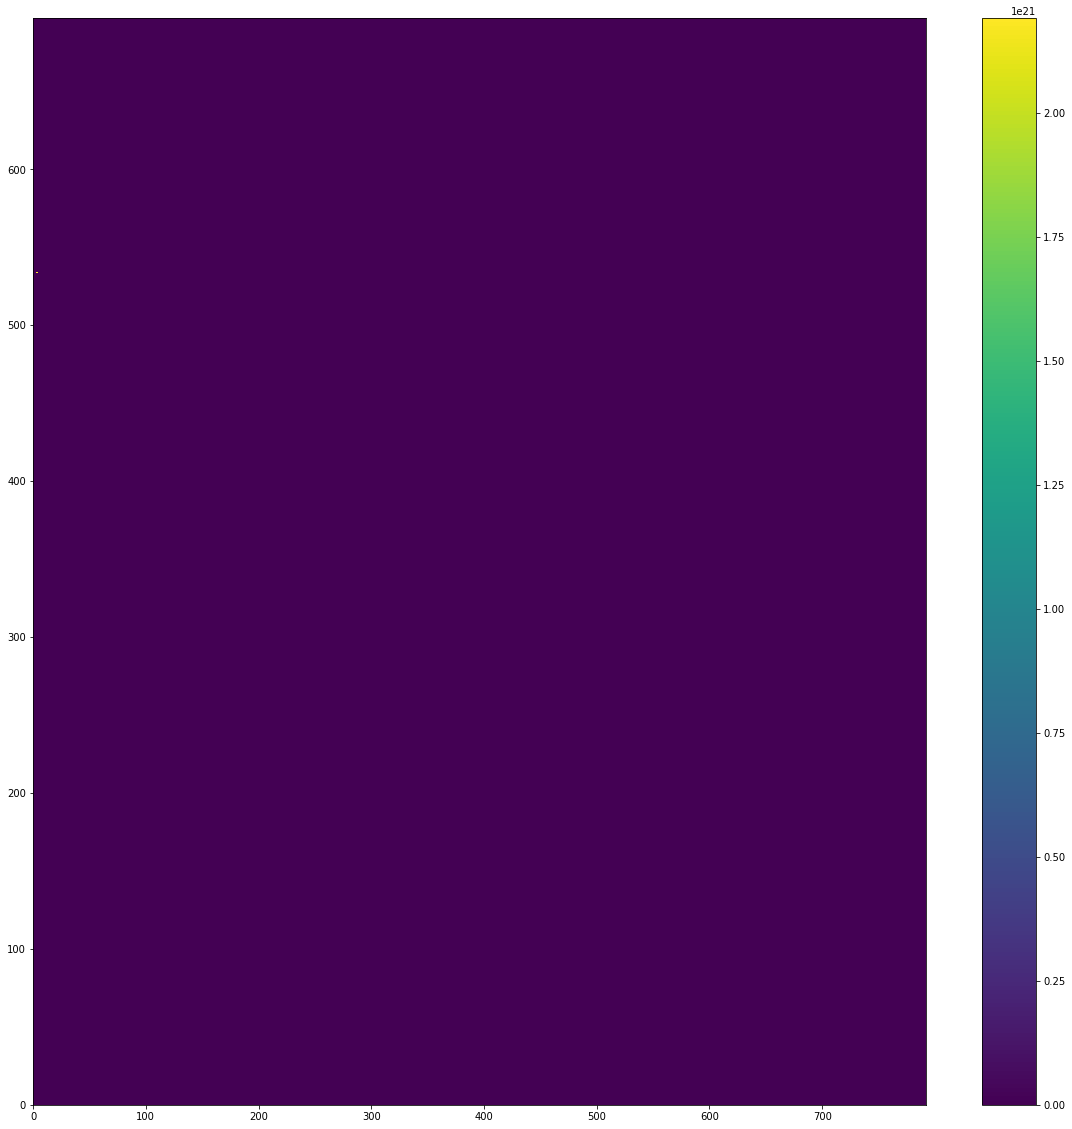

In [68]:
import scipy.stats
plt.figure(figsize=(20,20));
# plt.pcolormesh(scipy.stats.zscore(pred_models[:,feature_inds_defined,mm]))
plt.pcolormesh(pred_models[:,feature_inds_defined,mm])
plt.colorbar()

/home/mmhender/myenv/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


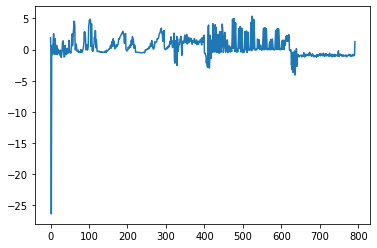

In [71]:
plt.figure();
zfeat = scipy.stats.zscore(pred_models[:,feature_inds_defined,mm])
plt.plot(zfeat[533,:])

In [100]:
mm

353

In [78]:
np.argmin(zfeat[533,:])

2

In [110]:
images[533]

188

In [111]:
images.shape

(697,)

In [100]:
from utils import nsd_utils
from utils import prf_utils
image_data = nsd_utils.get_image_data(subject=1)
image_data = nsd_utils.image_uncolorize_fn(image_data)

image_data.shape

In [102]:
# Need to have size a multiple of 8, for the pyramid to work right
process_at_size=240
# resample_fn = torch.nn.Upsample((process_at_size, \
#                                  process_at_size), mode="bilinear", align_corners=True)


AttributeError: module 'torch.nn' has no attribute 'Interpolate'

In [49]:
image_batch_resam_cpu.shape

torch.Size([3, 1, 240, 240])

In [53]:
torch.max(image_batch_resam_cpu-image_batch_resam)

tensor(1.7881e-07, device='cuda:0')

In [113]:
import torchvision

In [116]:
import skimage

In [118]:
from skimage.transform import resize

In [140]:
import PIL
from utils import texture_utils
n_pix = 240    
mm=353
prf_models = models
x,y,sigma = prf_models[mm,:]
aperture=1.0
g = prf_utils.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float64)
spatial_weights = g[2][0]
image_batch = torch.Tensor(image_data[187:190,:,:,:]).to(device)
i = image_batch.cpu().numpy()[0,0,:,:]
# image_batch_resam = resample_fn(image_batch)
image_batch_resam = np.asarray(PIL.Image.fromarray(i).resize((process_at_size, \
                                 process_at_size), resample=PIL.Image.BILINEAR))
image_batch_resam = torch.Tensor(image_batch_resam).to(device).view([1,1,process_at_size, process_at_size])
# image_batch_resam = torch.nn.functional.interpolate(image_batch, (process_at_size, \
#                                  process_at_size), mode="bilinear", align_corners=True)
# image_batch_resam = resize(image_batch, (image_batch.shape[0], image_batch.shape[1], process_at_size, \
#                                  process_at_size), anti_aliasing=True)
wmean, wvar, wskew, wkurt = \
    texture_utils.get_weighted_pixel_features(image_batch_resam, spatial_weights, device=device)

# image_batch = torch.Tensor(image_data[187:190,:,:,:]).to('cpu:0')
# image_batch_resam = np.asarray(PIL.Image.fromarray(image_batch.cpu().numpy()).resize(newsize, resample=PIL.Image.BILINEAR))
# # image_batch_resam_cpu = resample_fn(image_batch)
# # image_batch_resam_cpu  = torch.nn.functional.interpolate(image_batch, (process_at_size, \
# #                                  process_at_size), mode="bilinear", align_corners=True)
# # image_batch_resam_cpu = resize(image_batch, (image_batch.shape[0], image_batch.shape[1], process_at_size, \
# #                                  process_at_size), anti_aliasing=False)
# # image_batch_resam_cpu = image_batch_resam_cpu.to(device)
# wmean_cpu, wvar_cpu, wskew_cpu, wkurt_cpu = \
#     texture_utils.get_weighted_pixel_features(image_batch_resam_cpu, spatial_weights, device=device)


In [105]:
[wmean_cpu, wmean]

[tensor([[0.8156],
         [1.0000],
         [0.3752]], device='cuda:0'),
 tensor([[0.8156],
         [1.0000],
         [0.3752]], device='cuda:0')]

In [141]:
[wskew_cpu, wskew]

[tensor([[-1.8848e+00],
         [-3.7891e+02],
         [ 2.7598e-01]], device='cuda:0'),
 tensor([[-1.8954]], device='cuda:0')]

In [142]:
wskew

tensor([[-1.8954]], device='cuda:0')

In [130]:
wkurt_cpu, wkurt

(tensor([[6.1174e+00],
         [3.6712e+10],
         [5.8108e+00]], device='cuda:0'),
 tensor([[6.1704e+00],
         [2.1856e+21],
         [5.7683e+00]], device='cuda:0'))

In [39]:
wskew_cpu.device

device(type='cpu')

In [54]:
from utils import torch_utils

image_batch = image_batch_resam

if isinstance(image_batch, np.ndarray):
    image_batch = torch_utils._to_torch(image_batch, device).contiguous()
if isinstance(spatial_weights, np.ndarray):
    spatial_weights = torch_utils._to_torch(spatial_weights, device)

assert(image_batch.shape[2]==spatial_weights.shape[0] and image_batch.shape[3]==spatial_weights.shape[1])
assert(image_batch.shape[1]==1)

batch_size = image_batch.shape[0]
n_channels = image_batch.shape[1]
n_pix = image_batch.shape[2]

image_batch = image_batch.view([batch_size, n_channels, n_pix**2])
spatial_weights = spatial_weights/torch.sum(spatial_weights)
spatial_weights = spatial_weights.view([1,1,n_pix**2]).expand([batch_size,n_channels,-1]) # [batch_size x n_channels x nPix x nPix]    

ims_weighted = image_batch * spatial_weights

wmean = torch.sum(ims_weighted, axis=2).view([batch_size,-1,1])

wvar = torch.sum(spatial_weights * (image_batch - wmean.expand([-1,-1,n_pix**2]))**2, axis=2).view([batch_size,-1,1])

wskew = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**3 / (wvar**(3/2)), axis=2).view([batch_size,-1,1])

wkurt = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**4 / (wvar**(2)), axis=2).view([batch_size,-1,1])

# correct for nans/inf values which happen when variance is very small (denominator)
wskew[torch.isnan(wskew)] = 0.0
wkurt[torch.isnan(wkurt)] = 0.0
wskew[torch.isinf(wskew)] = 0.0
wkurt[torch.isinf(wkurt)] = 0.0

In [55]:
wskew

tensor([[[-1.8848e+00]],

        [[-4.4426e+10]],

        [[ 2.7598e-01]]], device='cuda:0')

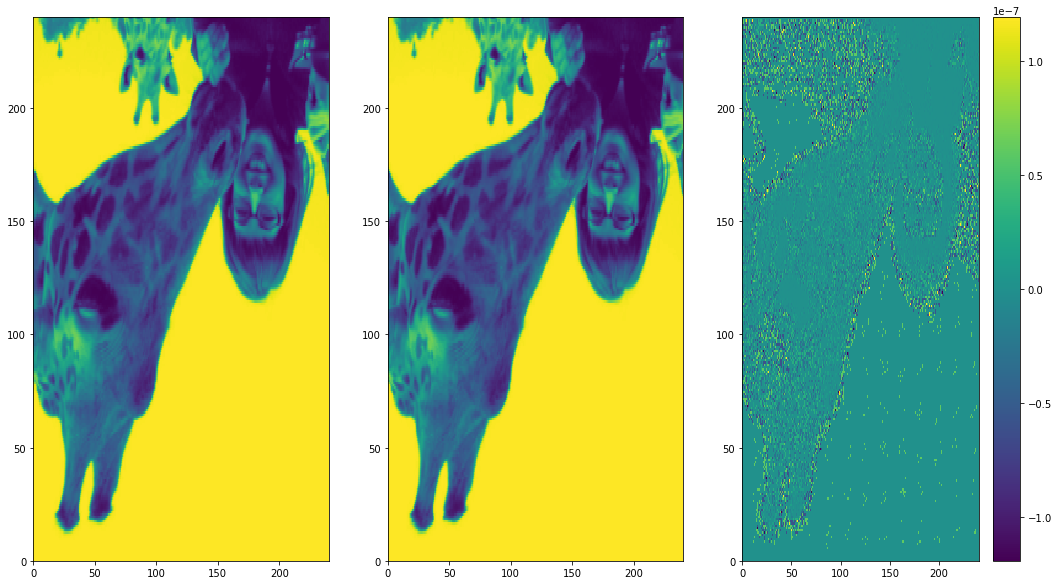

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10));
plt.subplot(1,3,1)
plt.pcolormesh(image_batch_resam[1,0,:].detach().cpu().numpy());
plt.subplot(1,3,2)
plt.pcolormesh(image_batch_resam_cpu[1,0,:].detach().cpu().numpy());
plt.subplot(1,3,3)
plt.pcolormesh(image_batch_resam[1,0,:].detach().cpu().numpy() - image_batch_resam_cpu[1,0,:].detach().cpu().numpy());
plt.colorbar()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

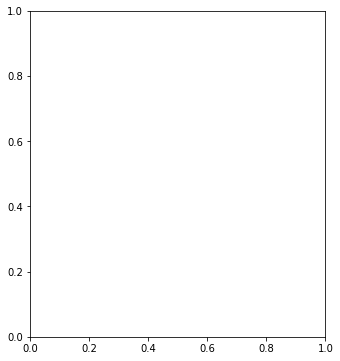

In [129]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6));
plt.subplot(1,3,1)
plt.pcolormesh((image_batch_resam[1,0,:].detach().cpu().numpy()-wmean[1].detach().cpu().numpy())*spatial_weights);
plt.colorbar()
plt.axis('square')
plt.subplot(1,3,2)
plt.pcolormesh((image_batch_resam_cpu[1,0,:].detach().cpu().numpy()-wmean[1].detach().cpu().numpy())*spatial_weights);
plt.colorbar()
plt.axis('square')
plt.subplot(1,3,3)
plt.pcolormesh((image_batch_resam[1,0,:].detach().cpu().numpy() - image_batch_resam_cpu[1,0,:].detach().cpu().numpy())*spatial_weights);
plt.colorbar()
plt.axis('square')

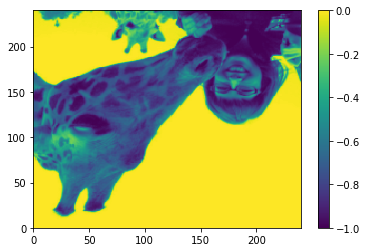

In [90]:
plt.figure();
plt.pcolormesh((image_batch_resam[1,0,:].detach().cpu().numpy()-wmean[1].detach().cpu().numpy()))
plt.colorbar()

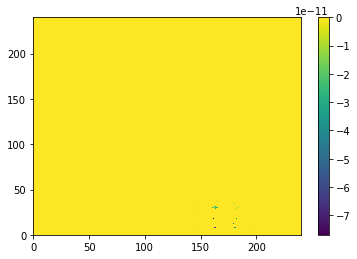

In [92]:
plt.figure();
plt.pcolormesh(spatial_weights*(image_batch_resam_cpu[1,0,:].detach().cpu().numpy()-wmean_cpu[1].detach().cpu().numpy()))
plt.colorbar()

In [98]:
thing = spatial_weights*(image_batch_resam_cpu[1,0,:].detach().cpu().numpy()-wmean_cpu[1].detach().cpu().numpy())
thing2 = spatial_weights*(image_batch_resam[1,0,:].detach().cpu().numpy()-wmean[1].detach().cpu().numpy())

In [99]:
import scipy.stats
scipy.stats.skew(thing.ravel())
scipy.stats.skew(thing2.ravel())

-39.55571801534067

In [22]:
spatial_weights_cpu = spatial_weights.cpu()
image_batch_cpu = image_batch.cpu()
wmean_cpu = wmean.cpu()
wvar_cpu = wvar.cpu()

In [23]:

wskew_cpu = torch.sum(spatial_weights_cpu *(image_batch_cpu - wmean_cpu.expand([-1,-1,n_pix**2]))**3 / (wvar_cpu**(3/2)),\
                      axis=2).view([batch_size,-1,1])


In [27]:
wskew_cpu

tensor([[[-1.8848e+00]],

        [[-4.4426e+10]],

        [[ 2.7598e-01]]])

In [157]:
values[187:190,2]

array([-1.88478065e+00, -4.44261007e+10,  2.75983393e-01])

In [158]:
wmean

tensor([[0.8156],
        [1.0000],
        [0.3752]])

In [159]:
values[187:190,0]

array([0.81560135, 1.        , 0.37517709])

In [160]:
wvar.dtype

torch.float32

In [155]:
values[187:190,1][0].dtype

dtype('float64')

In [124]:
pred_models[533,2,mm]

-44426100000.0

In [99]:
image_batch.shape

torch.Size([2, 1, 240, 240])

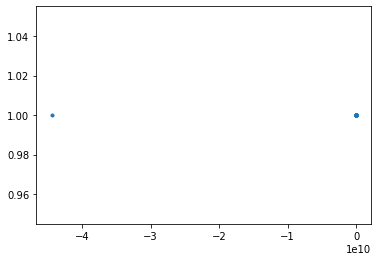

In [84]:
skewvals = pred_models[:,2,mm]
plt.figure();
# plt.hist(skewvals,100);
plt.plot(skewvals, np.ones(np.shape(skewvals)),'.')

In [85]:
prf_models[mm]

array([0.20263158, 0.43421053, 0.04      ])

In [88]:
# skewvals

In [53]:
f= pred_models[533,feature_inds_defined,mm]
np.argmin(f)

2

In [125]:
mm

353

In [172]:
import h5py
t = time.time()
with h5py.File(_feature_extractor.modules[0].features_file, 'r') as data_set:
    values_old = np.copy(data_set['/features'][:,:,mm])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)


Took 99.72373 seconds to load file


In [173]:
values_old[:,2][188]

-44426100736.0

In [40]:
import h5py
t = time.time()
fn2load = '/user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf_TEST.h5py'
with h5py.File(fn2load, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,mm])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)


Took 18.99672 seconds to load file


In [41]:
values[:,2][188]

-378.91162109375

In [130]:
values.shape

(10000, 641)

In [141]:
values[188,2]

-44426100736.0

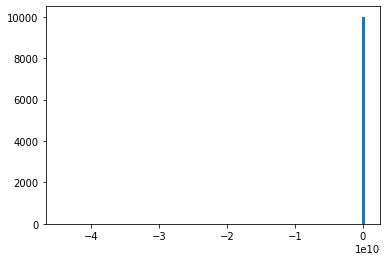

In [133]:
plt.figure();
plt.hist(values[:,2],100);

In [140]:
np.sum(values[:,2]<-1000000)

3

In [120]:
x,y,sigma

(0.2026315789473685, 0.4342105263157895, 0.03999999910593033)

In [86]:
# images[2]

In [60]:
w = weights[0,:,2]

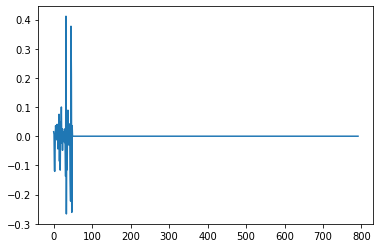

In [61]:
plt.figure;
plt.plot(w)

In [87]:
# w

In [42]:
    vv=-1
    ## Looping over voxels here in batches, will eventually go through all.
    for rv, lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
        vv=vv+1
        print('Getting predictions for voxels [%d-%d] of %d'%(rv[0],rv[-1],n_voxels))

        if vv>1 and debug:
            break

        # Looping over versions of model w different features set to zero (variance partition)
        for pp in range(n_partial_versions):

            print('\nEvaluating version %d of %d: %s'%(pp, n_partial_versions, partial_version_names[pp]))

            # masks describes the indices of the features that are included in this partial model
            # n_features_max in length
            features_to_use = masks[:,pp]==1
            print('Includes %d features'%np.sum(features_to_use))

            # [trials x features x voxels]
            features_full = pred_models[:,:,best_model_inds[rv,pp]]
            # Take out the relevant features now
            features_full = features_full[:,features_to_use,:]
            # Note there may be some zeros in this matrix, if we used fewer than the max number of features.
            # But they are zero in weight matrix too, so turns out ok.

            _weights = torch_utils._to_torch(weights[rv,:,pp], device=device)   
            _weights = _weights[:, features_to_use]
            _bias = torch_utils._to_torch(bias[rv,pp], device=device)

            print('number of zeros:')
            print(np.sum(features_full[0,:,0]==0))

            print('size of weights is:')
            print(_weights.shape)

            if features_mt is not None:
                _features_m = torch_utils._to_torch(features_mt[rv,:], device=device)
                _features_m = _features_m[:,features_to_use]
            if features_st is not None:
                _features_s = torch_utils._to_torch(features_st[rv,:], device=device)
                _features_s = _features_s[:,features_to_use]

            pred_block = np.full(fill_value=0, shape=(n_trials, lv), dtype=dtype)

            # Now looping over validation set trials in batches
            for rt, lt in numpy_utils.iterate_range(0, n_trials, sample_batch_size):

                _features = torch_utils._to_torch(features_full[rt,:], device=device) # trials x features
                if features_mt is not None:    
                    # features_m is [nvoxels x nfeatures] - need [trials x features x voxels]
                    _features = _features - torch.tile(torch.unsqueeze(_features_m, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])

                if features_st is not None:
                    _features = _features/torch.tile(torch.unsqueeze(_features_s, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])
                    # if any entries in std are zero or nan, this gives bad result - fix these now.
                    # these bad entries will also be zero in weights, so doesn't matter. just want to avoid nans.
                    _features[torch.isnan(_features)] = 0.0 
                    _features[torch.isinf(_features)] = 0.0

                # features is [#samples, #features, #voxels] - swap dims to [#voxels, #samples, features]
                _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
                # weights is [#voxels, #features]
                # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]

                _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(_weights, 2)), dim=2).t() 

                if _bias is not None:
                    _r = _r + torch.tile(torch.unsqueeze(_bias, 0), [_r.shape[0],1])

                pred_block[rt] = torch_utils.get_value(_r) 

            # Making sure to save these so that we can get stacking performance later.
            pred_voxel_data[:,rv,pp] = pred_block

            # Now for this batch of voxels and this partial version of the model, measure performance.
            val_cc[rv,pp] = get_corrcoef(voxel_data[:,rv], pred_block, axis=0)
            val_r2[rv,pp] = get_r2(voxel_data[:,rv], pred_block, axis=0)

            sys.stdout.flush()

# any nans become zeros here.
val_cc = np.nan_to_num(val_cc)
val_r2 = np.nan_to_num(val_r2) 

NameError: name 'prf_models' is not defined

In [17]:
val_cc, val_r2, val_voxel_data_pred  = validate_fwrf_model(best_params, models, val_voxel_data[:,vinds2use], \
                                                                                val_stim_data, _feature_extractor, \
                                   sample_batch_size=sample_batch_size, voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)

Clearing precomputed features from memory.
Clearing features from memory
Getting features for prf 353: [x,y,sigma] is [0.20 0.43 0.0400]
Loading pre-computed features for models [350 - 399] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 123.15037 seconds to load file
Index into batch for prf 353: 3
Size of features array for this image set and prf is:
(697, 641)
Final size of features concatenated is [697 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [697 x 641]
Final size of features concatenated 

In [18]:
val_cc

array([[0.01777613, 0.01777613, 0.01777613, 0.02915171, 0.01777613,
        0.04053882, 0.00893185],
       [0.03447067, 0.03447067, 0.03447067, 0.03800093, 0.03447067,
        0.08110691, 0.05354673]], dtype=float32)

In [22]:
val_r2[0,2]

-1.9178518e+17

In [28]:
dat = val_voxel_data[:,vinds2use[0]]

In [29]:
dat.shape

(697,)

In [30]:
datpred = val_voxel_data_pred[:,0,2]

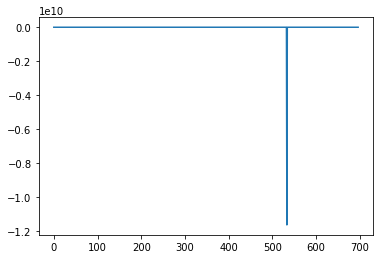

In [37]:
import matplotlib.pyplot as plt
plt.figure();
# plt.plot(dat)
plt.plot(datpred)

In [39]:
np.argmin(datpred)

533

In [40]:
datpred[533]

-11646300000.0

In [41]:
np.sum(datpred<-1000)

1

In [45]:
n_voxels = trn_voxel_data.shape[1]

# To get the "features" to use for stacking - i'm using the "partial models" that are defined 
# by the feature extractor. The first one is the full model, so we don't want to use that - just want 
# the ones that include just a subset of the full feature space.
partial_masks, partial_version_names = _feature_extractor.get_partial_versions()
partial_models_use = []
hasattr(_feature_extractor, 'module_names')
for mm in range(len(_feature_extractor.module_names)):
    this_module = np.where([(_feature_extractor.module_names[mm] in pp) for pp in partial_version_names])[0]
    if len(this_module)>1:
        # this means there are 'subsets' of features within this module that we will want to consider separately.
        # so finding just the ones that we want here.
        partial_models_use += list(np.where([(_feature_extractor.module_names[mm] in pp and '_just' in pp and '_no_other_modules' in pp) \
                     for pp in partial_version_names])[0])
    else:
        partial_models_use += list(this_module)
print('Subsets of features that are going into the stacking analysis:')
print([partial_version_names[pp] for pp in partial_models_use])

n_feature_groups = len(partial_models_use)

# Creating a list where each element is predictions for one of the partial models - these will be 
# the 'features' elements input to stacking code.
preds_train = [trn_voxel_data_pred[:,:,pp].T for pp in partial_models_use]
preds_val = [val_voxel_data_pred[:,:,pp] for pp in partial_models_use]
# Compute trial-wise training errors
# each element of err is [ntrials x nvoxels]
train_err = [trn_voxel_data[:,vinds2use] - trn_voxel_data_pred[:,:,pp].T for pp in partial_models_use]

# Also computing the performance of each of the partial versions on training set data.
# this is sort of a sanity check that things are working, since the performance of the partial models
# should roughly predict what the stacking weights will be.
train_r2 = np.array([get_r2(trn_voxel_data[:,vinds2use], trn_voxel_data_pred[:,:,pp].T, axis=0) \
                     for pp in range(len(partial_version_names))]).T
train_r2 = np.nan_to_num(train_r2)
train_cc = np.array([get_corrcoef(trn_voxel_data[:,vinds2use], trn_voxel_data_pred[:,:,pp].T, axis=0) \
                     for pp in range(len(partial_version_names))]).T
train_cc = np.nan_to_num(train_cc)

# First running stacking w all features included
feat_use = np.arange(0,n_feature_groups)

Subsets of features that are going into the stacking analysis:
['pyramid_texture_just_lower-level_no_other_modules', 'pyramid_texture_just_higher-level_no_other_modules', 'just_sketch_tokens']


In [46]:
train_cc

array([[0.48238674, 0.41091463, 0.24397306, 0.31177798, 0.42447937,
        0.4575612 , 0.38233986],
       [0.41395876, 0.56622624, 0.34037608, 0.524405  , 0.39886725,
        0.31344116, 0.2598045 ]], dtype=float32)

In [49]:
train_data=trn_voxel_data[:,vinds2use];
val_data = val_voxel_data[:,vinds2use]; 

solvers.options["show_progress"] = False

print('Running stacking, feat_use is:')
print(feat_use)
n_voxels = train_data.shape[1]
n_feature_groups = len(feat_use) # feat use is the sub-set of feature groups to stack.
n_trials_train = train_data.shape[0]
n_trials_val = preds_val[0].shape[0]

dtype = train_data.dtype
stacked_pred_train = np.full(fill_value=0, shape=(n_trials_train, n_voxels), dtype=dtype)
stacked_pred_val = np.full(fill_value=0, shape=(n_trials_val, n_voxels), dtype=dtype)

# calculate error matrix for stacking
P = np.zeros((n_voxels, n_feature_groups, n_feature_groups))
idI = 0
for i in feat_use:
    idJ = 0
    for j in feat_use:
        # err is the trialwise, voxelwise, error for each model.
        # P will store the summed products of the error for each pair of models 
        # (if i=j, then it's the summed squared error).
        P[:, idI, idJ] = np.mean(train_err[i] * train_err[j], 0)
        idJ += 1
    idI += 1

idI = 0
idJ = 0

# PROGRAMATICALLY SET THIS FROM THE NUMBER OF FEATURES
q = matrix(np.zeros((n_feature_groups)))
G = matrix(-np.eye(n_feature_groups, n_feature_groups))
h = matrix(np.zeros(n_feature_groups))
A = matrix(np.ones((1, n_feature_groups)))
b = matrix(np.ones(1))

# Stacking weights will be stored here
S = np.zeros((n_voxels, n_feature_groups))


Running stacking, feat_use is:
[0 1 2]


In [66]:
partial_models_use

[2, 3, 6]

In [67]:
np.mean((trn_voxel_data[:,vinds2use[0]]-trn_voxel_data_pred[0,:,2])**2)

0.9353744378019074

In [60]:
trn_voxel_data_pred.shape

(2, 688, 7)

In [52]:
P[0,:,:]

array([[0.93537444, 0.90591204, 0.86681897],
       [0.90591204, 0.92387216, 0.86889361],
       [0.86681897, 0.86889361, 0.87158037]])

In [56]:
train_r2[0,partial_models_use]

array([0.05899372, 0.07056525, 0.12317189])

In [9]:
from __future__ import division
import sys
import time
import numpy as np
import copy
import torch
from cvxopt import matrix, solvers

from utils import numpy_utils, torch_utils


def get_r2(actual,predicted,axis=0):
    """
    This computes the coefficient of determination (R2).
    Specify which axis to compute along (i.e. the trials/samples dimension)
    """
    ssres = np.sum(np.power((predicted - actual),2), axis=0);
    sstot = np.sum(np.power((actual - np.mean(actual)),2), axis=0);
    r2 = 1-(ssres/sstot)
    
    return r2

def get_corrcoef(actual,predicted,axis=0,dtype=np.float32):
    """
    This computes the linear correlation coefficient.
    Specify which axis to compute along (i.e. the trials/samples dimension)
    Assume input is 2D.
    """
    assert(len(actual.shape)==2)
    loop_axis = 1-axis;
    vals_cc = np.full(fill_value=0, shape=(actual.shape[loop_axis],), dtype=dtype)
    for vv in range(actual.shape[loop_axis]):
        vals_cc[vv] = np.corrcoef(actual[:,vv], predicted[:,vv])[0,1] 
    return vals_cc
 
def validate_fwrf_model(best_params, prf_models, voxel_data, images, _feature_extractor, \
                                   sample_batch_size=100, voxel_batch_size=100, debug=False, dtype=np.float32):
    
    """ 
    Evaluate trained model, leaving out a subset of features at a time.
    """
    
    params = best_params
    device = _feature_extractor.device
    
    n_trials, n_voxels = len(images), len(params[0])
    n_prfs = prf_models.shape[0]
    n_features = params[1].shape[1]  
    n_voxels = np.shape(voxel_data)[1]

    best_models, weights, bias, features_mt, features_st, best_model_inds = params
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    masks = np.transpose(masks)    
    n_features_max = _feature_extractor.max_features
    n_partial_versions = len(partial_version_names)
    
    # val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
    val_cc  = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)
    val_r2 = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)

    pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
    feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)
    
    # Saving full trial-by-trial predictions for each voxel, each partial model.
    # Need these for stacking.
    pred_voxel_data = np.full(fill_value=0, shape=(n_trials, n_voxels, n_partial_versions), dtype=dtype)
    
    start_time = time.time()    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # First gather texture features for all pRFs.
        
        _feature_extractor.clear_big_features()
        
        for mm in [353]:
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
            print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
            # all_feat_concat is size [ntrials x nfeatures]
            # nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
            all_feat_concat, feature_inds_defined = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)
            
            pred_models[:,feature_inds_defined,mm] = torch_utils.get_value(all_feat_concat)
            feature_inds_defined_each_prf[:,mm] = feature_inds_defined
            
        _feature_extractor.clear_big_features()
        
        vv=-1
        ## Looping over voxels here in batches, will eventually go through all.
        for rv, lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
            vv=vv+1
            print('Getting predictions for voxels [%d-%d] of %d'%(rv[0],rv[-1],n_voxels))

            if vv>1 and debug:
                break

            # Looping over versions of model w different features set to zero (variance partition)
            for pp in range(n_partial_versions):

                print('\nEvaluating version %d of %d: %s'%(pp, n_partial_versions, partial_version_names[pp]))

                # masks describes the indices of the features that are included in this partial model
                # n_features_max in length
                features_to_use = masks[:,pp]==1
                print('Includes %d features'%np.sum(features_to_use))

                # [trials x features x voxels]
                features_full = pred_models[:,:,best_model_inds[rv,pp]]
                # Take out the relevant features now
                features_full = features_full[:,features_to_use,:]
                # Note there may be some zeros in this matrix, if we used fewer than the max number of features.
                # But they are zero in weight matrix too, so turns out ok.

                _weights = torch_utils._to_torch(weights[rv,:,pp], device=device)   
                _weights = _weights[:, features_to_use]
                _bias = torch_utils._to_torch(bias[rv,pp], device=device)

                print('number of zeros:')
                print(np.sum(features_full[0,:,0]==0))

                print('size of weights is:')
                print(_weights.shape)

                if features_mt is not None:
                    _features_m = torch_utils._to_torch(features_mt[rv,:], device=device)
                    _features_m = _features_m[:,features_to_use]
                if features_st is not None:
                    _features_s = torch_utils._to_torch(features_st[rv,:], device=device)
                    _features_s = _features_s[:,features_to_use]

                pred_block = np.full(fill_value=0, shape=(n_trials, lv), dtype=dtype)

                # Now looping over validation set trials in batches
                for rt, lt in numpy_utils.iterate_range(0, n_trials, sample_batch_size):

                    _features = torch_utils._to_torch(features_full[rt,:], device=device) # trials x features
                    if features_mt is not None:    
                        # features_m is [nvoxels x nfeatures] - need [trials x features x voxels]
                        _features = _features - torch.tile(torch.unsqueeze(_features_m, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])

                    if features_st is not None:
                        _features = _features/torch.tile(torch.unsqueeze(_features_s, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])
                        # if any entries in std are zero or nan, this gives bad result - fix these now.
                        # these bad entries will also be zero in weights, so doesn't matter. just want to avoid nans.
                        _features[torch.isnan(_features)] = 0.0 
                        _features[torch.isinf(_features)] = 0.0
                        
                    # features is [#samples, #features, #voxels] - swap dims to [#voxels, #samples, features]
                    _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
                    # weights is [#voxels, #features]
                    # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]

                    _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(_weights, 2)), dim=2).t() 

                    if _bias is not None:
                        _r = _r + torch.tile(torch.unsqueeze(_bias, 0), [_r.shape[0],1])

                    pred_block[rt] = torch_utils.get_value(_r) 
                
                # Making sure to save these so that we can get stacking performance later.
                pred_voxel_data[:,rv,pp] = pred_block
                
                # Now for this batch of voxels and this partial version of the model, measure performance.
                val_cc[rv,pp] = get_corrcoef(voxel_data[:,rv], pred_block, axis=0)
                val_r2[rv,pp] = get_r2(voxel_data[:,rv], pred_block, axis=0)

                sys.stdout.flush()

    # any nans become zeros here.
    val_cc = np.nan_to_num(val_cc)
    val_r2 = np.nan_to_num(val_r2) 
    
    return val_cc, val_r2, pred_voxel_data


def run_stacking(_feature_extractor, trn_voxel_data, val_voxel_data, trn_voxel_data_pred, val_voxel_data_pred, debug=False):   
    """
    Get data organized to run stacking code (stacked_core)
    """
    n_voxels = trn_voxel_data.shape[1]

    # To get the "features" to use for stacking - i'm using the "partial models" that are defined 
    # by the feature extractor. The first one is the full model, so we don't want to use that - just want 
    # the ones that include just a subset of the full feature space.
    partial_masks, partial_version_names = _feature_extractor.get_partial_versions()
    partial_models_use = []
    hasattr(_feature_extractor, 'module_names')
    for mm in range(len(_feature_extractor.module_names)):
        this_module = np.where([(_feature_extractor.module_names[mm] in pp) for pp in partial_version_names])[0]
        if len(this_module)>1:
            # this means there are 'subsets' of features within this module that we will want to consider separately.
            # so finding just the ones that we want here.
            partial_models_use += list(np.where([(_feature_extractor.module_names[mm] in pp and '_just' in pp and '_no_other_modules' in pp) \
                         for pp in partial_version_names])[0])
        else:
            partial_models_use += list(this_module)
    print('Subsets of features that are going into the stacking analysis:')
    print([partial_version_names[pp] for pp in partial_models_use])

    n_feature_groups = len(partial_models_use)

    # Creating a list where each element is predictions for one of the partial models - these will be 
    # the 'features' elements input to stacking code.
    preds_train = [trn_voxel_data_pred[:,:,pp].T for pp in partial_models_use]
    preds_val = [val_voxel_data_pred[:,:,pp] for pp in partial_models_use]
    # Compute trial-wise training errors
    # each element of err is [ntrials x nvoxels]
    train_err = [trn_voxel_data - trn_voxel_data_pred[:,:,pp].T for pp in partial_models_use]

    # Also computing the performance of each of the partial versions on training set data.
    # this is sort of a sanity check that things are working, since the performance of the partial models
    # should roughly predict what the stacking weights will be.
    train_r2 = np.array([get_r2(trn_voxel_data, trn_voxel_data_pred[:,:,pp].T, axis=0) \
                         for pp in range(len(partial_version_names))]).T
    train_r2 = np.nan_to_num(train_r2)
    train_cc = np.array([get_corrcoef(trn_voxel_data, trn_voxel_data_pred[:,:,pp].T, axis=0) \
                         for pp in range(len(partial_version_names))]).T
    train_cc = np.nan_to_num(train_cc)

    # First running stacking w all features included
    feat_use = np.arange(0,n_feature_groups)
    # Stack result will be a tuple including the stacking weights, performance.
    stack_result = stacked_core(feat_use, train_err, train_data=trn_voxel_data,\
                     val_data = val_voxel_data, preds_train = preds_train, preds_val = preds_val,\
                     debug=debug);

    # Then going to repeat it leaving out one feature group at a time
    # This will only make sense to do there are more than 2 feature groups, otherwise it's just single models.
    if n_feature_groups>2:   
        stack_result_lo = dict()
        for leave_one in range(n_feature_groups):
            feat_use_lo = list(copy.deepcopy(feat_use))
            feat_use_lo.remove(leave_one)
            tmp = stacked_core(feat_use_lo, train_err, train_data=trn_voxel_data,\
                             val_data = val_voxel_data, preds_train = preds_train, preds_val = preds_val,\
                             debug=debug);
            stack_result_lo[leave_one] = tmp
    else:       
        stack_result_lo = None


    return stack_result, stack_result_lo, partial_models_use, train_r2, train_cc


def stacked_core(feat_use, train_err, train_data, val_data, preds_train, preds_val, debug=False):
    """
    Compute weights for stacking models (linearly combining predictions of multiple encoding models).
    Outputs weights and performance of the stacked model.
    Code from Ruogu Lin (modified slightly for this project).
    """
    
    solvers.options["show_progress"] = False

    print('Running stacking, feat_use is:')
    print(feat_use)
    n_voxels = train_data.shape[1]
    n_feature_groups = len(feat_use) # feat use is the sub-set of feature groups to stack.
    n_trials_train = train_data.shape[0]
    n_trials_val = preds_val[0].shape[0]
        
    dtype = train_data.dtype
    stacked_pred_train = np.full(fill_value=0, shape=(n_trials_train, n_voxels), dtype=dtype)
    stacked_pred_val = np.full(fill_value=0, shape=(n_trials_val, n_voxels), dtype=dtype)

    # calculate error matrix for stacking
    P = np.zeros((n_voxels, n_feature_groups, n_feature_groups))
    idI = 0
    for i in feat_use:
        idJ = 0
        for j in feat_use:
            # err is the trialwise, voxelwise, error for each model.
            # P will store the summed products of the error for each pair of models 
            # (if i=j, then it's the summed squared error).
            P[:, idI, idJ] = np.mean(train_err[i] * train_err[j], 0)
            idJ += 1
        idI += 1

    idI = 0
    idJ = 0

    # PROGRAMATICALLY SET THIS FROM THE NUMBER OF FEATURES
    q = matrix(np.zeros((n_feature_groups)))
    G = matrix(-np.eye(n_feature_groups, n_feature_groups))
    h = matrix(np.zeros(n_feature_groups))
    A = matrix(np.ones((1, n_feature_groups)))
    b = matrix(np.ones(1))

    # Stacking weights will be stored here
    S = np.zeros((n_voxels, n_feature_groups))

    for vv in range(0, n_voxels):
        if debug and vv>1:
            continue
            
        print('Solving for stacking weights for voxel %d of %d'%(vv, n_voxels))
        PP = matrix(P[vv])
        # solve for stacking weights for every voxel
        # This essentially is minimizing the quantity x.T @ PP @ x, subject to the constraint that
        # the elements of x have to be positive, and have to sum to 1. 
        # x will be the weights for the stacking model.
        # Weights will be dependent on the error of each model individually (this is contained in PP).
        S[vv, :] = np.array(solvers.qp(PP, q, G, h, A, b)["x"]).reshape(n_feature_groups,)
        if vv==0:
            print('Stacking weights matrix is size:')
            print(S.shape)
            
        # Combine the predictions from the individual feature spaces for voxel i
        z = np.array([preds_val[feature_j][:, vv] for feature_j in feat_use])
        # multiply the predictions by S[vv,:]
        stacked_pred_val[:, vv] = np.dot(S[vv, :], z)
        
        # Same thing for the training trials
        z = np.array([preds_train[feature_j][:, vv] for feature_j in feat_use])
        stacked_pred_train[:, vv] = np.dot(S[vv, :], z)
        
        sys.stdout.flush()
        
    print('Computing performance of stacked models')
    # Compute r2 of the stacked model for training data
    stacked_r2_train = get_r2(stacked_pred_train, train_data, axis=0)
    stacked_cc_train = get_corrcoef(stacked_pred_train, train_data, axis=0)
    stacked_r2_train = np.nan_to_num(stacked_r2_train)
    stacked_cc_train = np.nan_to_num(stacked_cc_train) 
    
    # And for validation data
    stacked_r2_val = get_r2(stacked_pred_val, val_data, axis=0)
    stacked_cc_val = get_corrcoef(stacked_pred_val, val_data, axis=0)
    stacked_r2_val = np.nan_to_num(stacked_r2_val)
    stacked_cc_val = np.nan_to_num(stacked_cc_val) 
    
    return S, stacked_r2_train, stacked_cc_train, stacked_r2_val, stacked_cc_val



In [8]:
import sys
import time
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

from utils import numpy_utils, torch_utils, texture_utils

"""
General code for fitting a 'feature weighted receptive field' model to fmri data - looping over many candidate pRF 
models for each voxel, find a set of weights that best predict its responses based on feature space of interest.
Can work for many different types of feature spaces, feature extraction implemented with nn.Module.

Original source of some of this code is the github repository:
https://github.com/styvesg/nsd
It was modified by MH to work for this project.
"""


def _cofactor_fn_cpu(_x, lambdas):
    '''
    Generating a matrix needed to solve ridge regression model for each lambda value.
    Ridge regression (Tikhonov) solution is :
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    This func will return (X^T*X + I*lambda)^-1 * X^T. 
    So once we have that, can just multiply by training data (Y) to get weights.
    returned size is [nLambdas x nFeatures x nTrials]
    This version makes sure that the torch inverse operation is done on the cpu, and in floating point-64 precision.
    Otherwise get bad results for small lambda values. This seems to be a torch-specific bug, noted around May 2021.
    
    '''
    device_orig = _x.device
    type_orig = _x.dtype
    # switch to this specific format which works with inverse
    _x = _x.to('cpu').to(torch.float64)
    _f = torch.stack([(torch.mm(torch.t(_x), _x) + torch.eye(_x.size()[1], device='cpu', dtype=torch.float64) * l).inverse() for l in lambdas], axis=0) 
    
    # [#lambdas, #feature, #feature] 
    cof = torch.tensordot(_f, _x, dims=[[2],[1]]) # [#lambdas, #feature, #sample]
    
    # put back to whatever way it was before, so that we can continue with other operations as usual
    return cof.to(device_orig).to(type_orig)



def _loss_fn(_cofactor, _vtrn, _xout, _vout):
    '''
    Calculate loss given "cofactor" from cofactor_fn, training data, held-out design matrix, held out data.
    returns weights (betas) based on equation
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    also returns loss for these weights w the held out data. SSE is loss func here.
    '''

    _beta = torch.tensordot(_cofactor, _vtrn, dims=[[2], [0]]) # [#lambdas, #feature, #voxel]
    _pred = torch.tensordot(_xout, _beta, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
    _loss = torch.sum(torch.pow(_vout[:,None,:] - _pred, 2), dim=0) # [#lambdas, #voxels]
    return _beta, _loss



def fit_fwrf_model(images, voxel_data, _feature_extractor, prf_models, lambdas, \
                   zscore=False, add_bias=False, voxel_batch_size=100, holdout_size=100, \
                       shuffle=True, shuff_rnd_seed=0, device=None, dtype=np.float32, debug=False):
    
    """
    Solve for encoding model weights using ridge regression.
    Inputs:
        images: the training images, [n_trials x 1 x height x width]
            OR for models where features were pre-computed, this is a list of indices [n_trials,] into the 10,000 long feature array.
        voxel_data: the training voxel data, [n_trials x n_voxels]
        _feature_extractor_fn: module that maps from images to model features
        prf_models: the list of possible pRFs to test, columns are [x, y, sigma]
        lambdas: ridge lambda parameters to test
        zscore: want to zscore each column of feature matrix before fitting?
        add_bias: add a column of ones to feature matrix, for an additive bias?
        voxel_batch_size: how many voxels to use at a time for model fitting
        holdout_size: how many training trials to hold out for computing loss/lambda selection?
        shuffle: do we shuffle training data order before holding trials out?      
        shuff_rnd_seed: if we do shuffle training data (shuffle=True), what random seed to use? if zero, choose a new random seed in this code.
        device: what device to use? cpu/cuda
        debug: want to run a shortened version of this, to test it?
    Outputs:
        best_losses: loss value for each voxel (with best pRF and best lambda), eval on held out set
        best_lambdas: best lambda for each voxel (chosen based on loss w held out set)
        best_params: 
            [0] best pRF for each voxel [x,y,sigma]
            [1] best weights for each voxel/feature
            [2] if add_bias=True, best bias value for each voxel
            [3] if zscore=True, the mean of each feature before z-score
            [4] if zscore=True, the std of each feature before z-score
            [5] index of the best pRF for each voxel (i.e. index of row in "prf_models")
        
    """

    if device is None:
        device=torch.device('cpu:0')

    print ('dtype = %s' % dtype)
    print ('device = %s' % device)

    n_trials = len(images)
    n_prfs = len(prf_models)
    n_voxels = voxel_data.shape[1]   

    # Get train/holdout splits.
    # Held-out data here is used for lamdba selection.
    # This is the inner part of nested cross-validation; there is another portion of data ('val') which never enters this function.
    trn_size = n_trials - holdout_size
    assert trn_size>0, 'Training size needs to be greater than zero'
    print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxel_data)))
    order = np.arange(len(voxel_data), dtype=int)
    if shuffle:
        if shuff_rnd_seed==0:
            print('Computing a new random seed')
            shuff_rnd_seed = int(time.strftime('%M%H%d', time.localtime()))
        print('Seeding random number generator: seed is %d'%shuff_rnd_seed)
        np.random.seed(shuff_rnd_seed)
        np.random.shuffle(order)
        
    images = images[order]
    voxel_data_shuff = copy.deepcopy(voxel_data)
    voxel_data_shuff = voxel_data_shuff[order]  
    trn_data = voxel_data_shuff[:trn_size]
    out_data = voxel_data_shuff[trn_size:]

    
    # Here is where any model-specific additional initialization steps are done
    # Includes initializing pca params arrays, if doing pca
    if len(images.shape)>1:
        image_size = images.shape[2:4]
    else:
        image_size = None
    _feature_extractor.init_for_fitting(image_size, prf_models, dtype)
    max_features = _feature_extractor.max_features

    # Decide whether to do any "partial" versions of the models (leaving out subsets of features)
    # Purpose is for variance partition
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    n_partial_versions = len(partial_version_names) # will be one if skipping varpart
    if add_bias:
        masks = np.concatenate([masks, np.ones([masks.shape[0],1])], axis=1) # always include intercept 
    masks = np.transpose(masks)
    # masks is [n_features_total (including intercept) x n_partial_versions]

    # Initialize arrays to store model fitting params
    best_w_params = np.zeros(shape=(n_voxels, max_features ,n_partial_versions), dtype=dtype)
    best_prf_models = np.full(shape=(n_voxels,n_partial_versions), fill_value=-1, dtype=int)   
    best_lambdas = np.full(shape=(n_voxels,n_partial_versions), fill_value=-1, dtype=int)
    best_losses = np.full(fill_value=np.inf, shape=(n_voxels,n_partial_versions), dtype=dtype)

    # Initialize arrays to store the trial-wise predictions (need these for stacking)
    # Note that this is all training set trials - including the held out trials.
    best_train_preds = np.zeros(shape=(n_voxels, n_trials, n_partial_versions), dtype=dtype)

    # Additional params that are optional
    if add_bias:
        best_w_params = np.concatenate([best_w_params, np.zeros(shape=(n_voxels,1,n_partial_versions), dtype=dtype)], axis=1)

    if zscore:
        features_mean = np.zeros(shape=(n_voxels, max_features), dtype=dtype)
        features_std  = np.zeros(shape=(n_voxels, max_features), dtype=dtype)
    else:
        features_mean = None
        features_std = None

    start_time = time.time()
    vox_loop_time = 0

    print ('---------------------------------------\n')
    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # Looping over prf_models (here prf_models are different spatial RF definitions)
        for m in [353]:
            x,y,sigma = prf_models[m]
#         for m,(x,y,sigma) in enumerate(prf_models):
#             if debug and m>1:
#                 break
                
            print('\nGetting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(m, prf_models[m,0],  prf_models[m,1],  prf_models[m,2]))

            t = time.time()            

            # Get features for the desired pRF, across all trn set image  
            # Features is size [ntrials x nfeatures]
            # nfeatures may be less than max_features, because max_features is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
            features, feature_inds_defined = _feature_extractor(images, (x,y,sigma), m, fitting_mode=True)
            features = features.detach().cpu().numpy() 
            
            elapsed = time.time() - t

            n_features_actual = features.shape[1]
            
            if zscore:  
                features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
                features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
                features -= features_m
                features /= features_s    

            if add_bias:
                features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
                feature_inds_defined = np.concatenate((feature_inds_defined, [True]), axis=0)
                
            trn_features = features[:trn_size,:]
            out_features = features[trn_size:,:]
            
            
            # Going to keep track of whether current prf is better than running best, for each voxel.
            # This is for the full model only.
            # Will use this to make sure for each partial model, we end up saving the params for the prf that was best w full model.
            full_model_improved = np.zeros((n_voxels,),dtype=bool)

            # Looping over versions of model w different features set to zero (variance partition)
            for pp in range(n_partial_versions):

                print('\nFitting version %d of %d: %s, '%(pp, n_partial_versions, partial_version_names[pp]))

                # nonzero_inds_full is length max_features (or max_features+1 if bias=True)
                # same size as the final params matrices will be.
                nonzero_inds_full = np.logical_and(masks[:,pp], feature_inds_defined)             
                # nonzero_inds_full is restricted to just indices that are defined for this prf - ie same size as features.
                nonzero_inds_short = masks[feature_inds_defined,pp]==1
        
                # Send matrices to gpu    
                _xtrn = torch_utils._to_torch(trn_features[:, nonzero_inds_short], device=device)
                _xout = torch_utils._to_torch(out_features[:, nonzero_inds_short], device=device)   

                # Do part of the matrix math involved in ridge regression optimization out of the loop, 
                # because this part will be same for all the voxels.
                _cof = _cofactor_fn_cpu(_xtrn, lambdas = lambdas) 

                # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
                vox_start = time.time()
                vi=-1
                for rv,lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
                    vi=vi+1
                    sys.stdout.write('\rfitting model %4d of %-4d, voxels [%6d:%-6d] of %d' % (m, n_prfs, rv[0], rv[-1], n_voxels))

                    # Send matrices to gpu
                    _vtrn = torch_utils._to_torch(trn_data[:,rv], device=device)
                    _vout = torch_utils._to_torch(out_data[:,rv], device=device)

                    # Here is where optimization happens - relatively simple matrix math inside loss fn.
                    _betas, _loss = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel]
                    
                    # Get trial-by-trial predictions for each training set trial (need for stacking)
                    _pred_train = torch.tensordot(_xtrn, _betas, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
                    _pred_out = torch.tensordot(_xout, _betas, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
                    pred_train = torch_utils.get_value(_pred_train)
                    pred_out = torch_utils.get_value(_pred_out)
                    # Going to combine the training and held out trials and re-create their original order here.
                    preds_all_shuffled = np.concatenate((pred_train, pred_out), axis=0)
                    preds_all_origorder = numpy_utils.unshuffle(preds_all_shuffled, order) # [#samples x lambdas x voxels]
    
                    # Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
                    # goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.

                    # choose best lambda value and the loss that went with it.
                    _loss_values, _lambda_index = torch.min(_loss, dim=0)
                    loss_values, lambda_index = torch_utils.get_value(_loss_values), torch_utils.get_value(_lambda_index)
                    betas = torch_utils.get_value(_betas)
                    
                    if pp==0:

                        # comparing this loss to the other prf_models for each voxel (e.g. the other RF position/sizes)
                        assert(partial_version_names[pp]=='full_model' or partial_version_names[pp]=='full_combined_model')               
                        imp = loss_values<best_losses[rv,pp]
                        full_model_improved[rv] = imp

                    else:

                        # for the partial models we don't actually care which was best for the partial model itself,
                        # just care what was best for the full model
                        imp = full_model_improved[rv]


                    if np.sum(imp)>0:

                        # for whichever voxels had improvement relative to previous prf_models, save parameters now
                        # this means we won't have to save all params for all prf_models, just best.
                        arv = np.array(rv)[imp]

                        lambda_inds = lambda_index[imp]
                        best_lambdas[arv,pp] = lambda_inds
                        best_losses[arv,pp] = loss_values[imp]                        
                        best_prf_models[arv,pp] = m
                        if zscore and pp==0:
                            
                            # only need to update the mean/std if we're working with the full model, because those will be same for all partial versions.
                            fmean_tmp = copy.deepcopy(features_mean[arv,:])
                            fstd_tmp = copy.deepcopy(features_std[arv,:])
                            fmean_tmp[:,nonzero_inds_full[0:-1]] = features_m[0,nonzero_inds_short[0:-1]] # broadcast over updated voxels
                            fmean_tmp[:,~nonzero_inds_full[0:-1]] = 0.0
                            fstd_tmp[:,nonzero_inds_full[0:-1]] = features_s[0,nonzero_inds_short[0:-1]] # broadcast over updated voxels
                            fstd_tmp[:,~nonzero_inds_full[0:-1]] = 0.0
                            features_mean[arv,:] = fmean_tmp
                            features_std[arv,:] = fstd_tmp
                            
                        # taking the weights associated with the best lambda value
                        # remember that they won't fill entire matrix, rest of values stay at zero
                        best_w_tmp = copy.deepcopy(best_w_params[arv,:,pp])
                        best_w_tmp[:,nonzero_inds_full] = numpy_utils.select_along_axis(betas[:,:,imp], lambda_inds, \
                                                                                        run_axis=2, choice_axis=0).T
                        best_w_tmp[:,~nonzero_inds_full] = 0.0 # make sure to fill zeros here
                        best_w_params[arv,:,pp] = best_w_tmp
                        
                        # Save the trialwise predictions for all trials in their original order.
                        # Choosing predictions from whichever lambda was best.
                        best_train_preds[arv,:,pp] = numpy_utils.select_along_axis(preds_all_origorder[:,:,imp], \
                                                                               lambda_inds, run_axis=2, choice_axis=1).T;

                vox_loop_time += (time.time() - vox_start)
                elapsed = (time.time() - vox_start)
                sys.stdout.flush()

    # Print information about how fitting went...
    total_time = time.time() - start_time
    inv_time = total_time - vox_loop_time
    return_params = [best_w_params[:,0:max_features,:],]
    if add_bias:
        return_params += [best_w_params[:,-1,:],]
    else: 
        return_params += [None,]
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('total throughput = %fs/voxel' % (total_time / n_voxels))
    print ('voxel throughput = %fs/voxel' % (vox_loop_time / n_voxels))
    print ('setup throughput = %fs/model' % (inv_time / n_prfs))
    
    # This step clears the big feature maps for training data from feature extractor (no longer needed)
    _feature_extractor.clear_big_features()
    
    best_params = [prf_models[best_prf_models],]+return_params+[features_mean, features_std]+[best_prf_models]
    sys.stdout.flush()

    return best_losses, best_lambdas, best_params, best_train_preds

In [9]:
 val_cc, val_r2, val_voxel_data_pred  = fwrf_predict.validate_fwrf_model(best_params, models, val_voxel_data, \
                                                                                val_stim_data, _feature_extractor, \
                                   sample_batch_size=sample_batch_size, voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)

Clearing precomputed features from memory.
Clearing features from memory
Getting features for prf 0: [x,y,sigma] is [-0.55 -0.55 0.0400]
Loading pre-computed features for models [0 - 49] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 104.68504 seconds to load file
Index into batch for prf 0: 0
Size of features array for this image set and prf is:
(62, 641)
Final size of features concatenated is [62 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [62 x 641]
Final size of features concatenated is [62 x

In [10]:
stack_result, stack_result_lo, partial_models_used_for_stack  = fwrf_predict.run_stacking(_feature_extractor, \
                                                     trn_voxel_data, val_voxel_data, trn_voxel_data_pred, val_voxel_data_pred, debug=debug)

Subsets of features that are going into the stacking analysis:
['pyramid_texture_just_lower-level_no_other_modules', 'pyramid_texture_just_higher-level_no_other_modules', 'just_sketch_tokens']
Running stacking, feat_use is:
[0 1 2]
Solving for stacking weights for voxel 0 of 14913
Stacking weights matrix is size:
(14913, 3)
Solving for stacking weights for voxel 1 of 14913
Computing performance of stacked models


/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Running stacking, feat_use is:
[1, 2]
Solving for stacking weights for voxel 0 of 14913
Stacking weights matrix is size:
(14913, 2)
Solving for stacking weights for voxel 1 of 14913
Computing performance of stacked models
Running stacking, feat_use is:
[0, 2]
Solving for stacking weights for voxel 0 of 14913
Stacking weights matrix is size:
(14913, 2)
Solving for stacking weights for voxel 1 of 14913
Computing performance of stacked models
Running stacking, feat_use is:
[0, 1]
Solving for stacking weights for voxel 0 of 14913
Stacking weights matrix is size:
(14913, 2)
Solving for stacking weights for voxel 1 of 14913
Computing performance of stacked models


In [24]:
partial_models_used_for_stack

[2, 3, 6]

In [25]:
out = torch.load('/user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_plus_sketch_tokens_stacked/Sep-25-2021_1718_53_DEBUG/all_fit_params')

In [29]:
out['partial_models_used_for_stack']

[2, 3, 6]